### Problem Statement
New buyers of residential properties are usually unfamiliar with the market prices. Depending on criterias such as locations, amenities, lot size and livable area, the price can varies greatly. As a data scientist, you would like to help buyers to determine the reasonable selling price for residential properties so that they are not over-paying for them and know when a property is a good deal.
Your tasks are:-
- Create a model to predict the sale price based on the features provided in the Ames Housing Dataset
- Identify the top 5 features which would greatly influence the price which the buyers should take note of

### Importing Libraries

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

### Functions Definition

In [163]:
def boxplot_count_subplot(x, feature_list, data, row, col, figure_size=(20, 15)):
    # This function plots boxplot and count bar graph for each feature as as subplots
    # Declaring and initialising variables
    fig, ax = plt.subplots(figsize=figure_size, nrows=2, ncols = 3)
    i = 0
    
    # Loop through feature_list to create subplot for each feature
    for feature in feature_list:
        sns.boxplot(x=x, y=feature, data=data, ax=ax[0,i], order=data[feature].value_counts().index)
        sns.barplot(x=data[feature].value_counts(),y=data[feature].value_counts().index, ax=ax[1, i])
        i+=1

#----------------------------------------------------------------------------------------------        
        
def corr_plots(data, heatmap_size=(8, 8), heatmap_title_fontsize = 16, pair_title_fontsize = 16):
    # Heatmap
    plt.figure(figsize=heatmap_size)
    pearson_corr = data.corr()
    mask = np.zeros_like(pearson_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(pearson_corr, annot=True, mask=mask, vmax = 1, vmin = -1)
    plt.title('Correlation Heatmap', fontweight = 'bold', fontsize=heatmap_title_fontsize)
    
    # Plot Pairplot
    pair = sns.pairplot(data)
    pair.fig.suptitle('Pairplot Between Features', fontweight = 'bold', fontsize=pair_title_fontsize)
    pair.fig.subplots_adjust(top=0.9)

#----------------------------------------------------------------------------------------------
    
def scatter_plot_3_features(data, x, y, features_list, rows, cols, 
                        figsize=(12,12), t_fontsize=10, t_dist_top = 0.9, marker_size=10):
    '''
    data: DataFrame of the data
    x: String. Numeric common feature to be set as x axis of all subplots
    y: String. Numeric common feature to be set as x axis of all subplots
    Features: List of strings to be set as hue in scatterplot
    rows: No of rows
    cols: No of cols
    figsize: tuple (Width, Height)
    '''
    fig, ax = plt.subplots(figsize=figsize, nrows=rows, ncols=cols)
    for i in range(len(features_list)):
        if rows > 1 and cols > 1:
            sns.scatterplot(x=x, y=y, data=data, hue=features_list[i], ax=ax[int(i/cols),i%cols], s=marker_size)
            ax[int(i/cols),i%cols].set_title(f"{y} vs {x} By {features_list[i]}")
        else:
            sns.scatterplot(x=x, y=y, data=data, hue=features_list[i], ax=ax[i], s=marker_size)
            ax[i].set_title(f"{y} vs {x} By {features_list[i]}")
    plt.suptitle(f"{y} vs {x} By Various Features", fontweight='bold', fontsize=t_fontsize)
    fig.subplots_adjust(top=t_dist_top)

#----------------------------------------------------------------------------------------------
    
def scatter_plot_by_labels(data, x, y, feature, rows, cols,
                          figsize=(12,12), t_fontsize=10, t_dist_top = 0.9, marker_size=10, ci=95):
    fig, ax = plt.subplots(figsize = figsize, nrows = rows, ncols = cols, sharex=True, sharey=True, squeeze=False)
    for i in range(data[feature].nunique()):
        sns.regplot(x=x, y=y, data=data[data[feature]==data[feature].unique()[i]],
                    ax=ax[int(i/cols),i%cols], ci=ci, line_kws={'color':'red'},
                    scatter_kws={'s':marker_size})
        ax[int(i/cols),i%cols].set_title(data[feature].unique()[i])
    fig.suptitle(f'{y} vs {x} by {feature}', fontsize=t_fontsize, fontweight="bold")
    fig.subplots_adjust(top=t_dist_top)

#----------------------------------------------------------------------------------------------

def prePost_logtransform(data, x, y, feature, label, figsize=(12,12), t_fontsize=10,
                         t_dist_top = 0.9):
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2, sharey=True)
    # Comparison of scatter plot before and after transformation of x 
    # Plot for Sale Price vs Lot Area - Before Transformation for feature = label
    sns.regplot(x=x, y=y, data=data[data[feature]==label], ax=ax[0])
    ax[0].set_title('Sale Price vs Lot Area - Before Transformation')
    ax[0].set_xticks(ax[0].get_xticks())
    ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)

    # Plot for Sale Price vs Lot Area - After Transformation for Neighborhood = Edwards
    sns.regplot(x=np.log(data[data[feature]==label][x]), y=data[data[feature]==label][y], ax=ax[1])
    ax[1].set_title('Sale Price vs Lot Area - After Transformation')

    # Set Main Title
    fig.suptitle(f'Effect of Transformation on Lot Area for {feature}: {label}', fontsize = t_fontsize, fontweight='bold')
    fig.subplots_adjust(top=t_dist_top)
    
    # Correlation Values
    temp = data[data[feature]==label].copy()
    new_x = x + '_log'
    temp[new_x] = np.log(temp[x])
    pearson_corr = temp[[x, new_x, y]].corr()
    print(pearson_corr)

#----------------------------------------------------------------------------------------------

def imputing_lot_frontage(data):
    temp = data[data['Lot Area'] < 30000][['Lot Area', 'Lot Frontage']]
    temp.dropna(inplace=True)

    # Train Test Split Data Set
    x_train, x_test, y_train, y_test = train_test_split(temp[['Lot Area']], temp['Lot Frontage'], train_size = 0.8, random_state=60)

    # Instantiate OLS Model
    lr = LinearRegression()
    lr.fit(x_train, y_train)

    # Get index for missing Lot Frontage data for Lot Area < 30000
    missing_index = data[(data['Lot Area'] < 30000) & (data['Lot Frontage'].isnull())]['Lot Frontage'].index

    # Imputing data and save into Lot Frontage_Imputed
    data['Lot Frontage_Imputed'] = data['Lot Frontage']
    for i in missing_index:
        data.loc[i, 'Lot Frontage_Imputed'] = lr.predict([[data.loc[i, 'Lot Area']]])
        
    return data 
    
#----------------------------------------------------------------------------------------------
    
def clean(data):
    data=data.copy()
    # Converting MS SubClass, Overall Qual, Overall Cond to string as it is categorical data
    data['MS SubClass'] = data['MS SubClass'].astype('str')
    data['Overall Qual'] = data['Overall Qual'].astype('str')
    data['Overall Cond'] = data['Overall Qual'].astype('str')
    
    # Replace all 'NaN' from object columns
    for column in data.columns:
        if data[column].dtype == 'O':
            if column in ['Mas Vnr Type', 'Misc Feature']:
                data[column].replace(np.nan, 'None', inplace=True)
            else:
                data[column].replace(np.nan, 'n.a', inplace=True)
    
    # New Column for 'Garage Yr Blt and Impute missing 'Garage Yr Blt' rows with 'Year Built' data
    data['Garage Yr Blt_Imputed'] = data['Garage Yr Blt'].fillna(value=data['Year Built'])
    
    # Imputing Lot Frontage based on Linear Regression Model using Lot Area
    data = imputing_lot_frontage(data)
               
    # Set 0 for rows with house style as 1story but 2nd level SF is not 0
    data.loc[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0), '2nd Flr SF'] = 0
    
    # Set 0 for rows with mas vnr type as None but Mas Vnr Area is not 0
    data.loc[data['Mas Vnr Type'] == 'None', 'Mas Vnr Area'] = 0
 
    return data

#----------------------------------------------------------------------------------------------

def prep(data):
    data=data.copy()
    # Engineering new numeric features
    data['Total SF'] = data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF']
    data['Total SF**2'] = (data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF'])**2
    data['No Of Bath'] = data['Bsmt Full Bath'] + (data['Bsmt Half Bath']/2) + data['Full Bath'] + (data['Half Bath']/2)
    data['Total Porch SF'] = data['Open Porch SF'] + data['Enclosed Porch'] + data['3Ssn Porch'] + data['Screen Porch']
    data['Amenities SF'] = data['Pool Area'] + data['Wood Deck SF'] + data['Garage Area']
    data['Age_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Remod/Add Age_Sold'] = data['Yr Sold'] - data['Year Remod/Add']
    data['Gr Liv Area**2'] = data['Gr Liv Area']**2

    # Dropping Lot Frontage and Garage Yr Blt
    data.drop(columns = ['Lot Frontage', 'Garage Yr Blt'], inplace=True)
                                                         
    return data

#----------------------------------------------------------------------------------------------

def residual_plot(model, predictors, target, fig_title):
    plt.scatter(model.predict(predictors), target - model.predict(predictors))
    plt.axhline(y = 0, color='red')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual (Target - Predicted)')
    plt.title(fig_title)

#----------------------------------------------------------------------------------------------

def output_result(model_type, features, Train_R2, Train_CV_R2, Test_R2, Train_RMSE, Train_CV_RMSE, Test_RMSE):
    results = pd.DataFrame([[model_type, str(features), Train_R2, Train_CV_R2, Test_R2, Train_RMSE, Train_CV_RMSE, Test_RMSE]])
    results.to_csv(r'..\datasets\results.csv', index=False, mode='a', header=False)

### Import and Clean Data

In [164]:
# Read, clean, drop columns and dropna rows for train.csv
null_values = ['','#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
               '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
data_ori = pd.read_csv('../datasets/train.csv', keep_default_na=False, na_values=null_values)
data = clean(data_ori)

# Drop Lot Frontage and Garage Yr Blt
data.drop(columns=['Lot Frontage', 'Garage Yr Blt'], inplace=True)

# Drop na rows
data.dropna(inplace=True)

In [87]:
data.head()

Id        PID MS SubClass MS Zoning  Lot Area Street Alley Lot Shape  \
0  109  533352170          60        RL     13517   Pave    NA       IR1   
1  544  531379050          60        RL     11492   Pave    NA       IR1   
2  153  535304180          20        RL      7922   Pave    NA       Reg   
3  318  916386060          60        RL      9802   Pave    NA       Reg   
4  255  906425045          50        RL     14235   Pave    NA       IR1   

  Land Contour Utilities  ... Pool QC Fence Misc Feature Misc Val Mo Sold  \
0          Lvl    AllPub  ...      NA    NA           NA        0       3   
1          Lvl    AllPub  ...      NA    NA           NA        0       4   
2          Lvl    AllPub  ...      NA    NA           NA        0       1   
3          Lvl    AllPub  ...      NA    NA           NA        0       4   
4          Lvl    AllPub  ...      NA    NA           NA        0       3   

  Yr Sold Sale Type SalePrice Garage Yr Blt_Imputed  Lot Frontage_Imputed  
0    2010       WD     130500                1976.0             84.912761  
1    2009       WD     220000                1997.0             43.000000  
2    2010       WD     109000                1953.0             68.000000  
3    2010       WD     174000                2007.0             73.000000  
4    2010       WD     138500                1957.0             82.000000  

[5 rows x 81 columns]

### EDA

In [88]:
# Filtering features with with type "object"
feature_typeObj = [data.dtypes.index[i] for i in range(len(data.dtypes)) if data.dtypes[i] == 'object']
feature_typeObj

['MS SubClass',
 'MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type']

In [89]:
# Filtering numeric features
feature_typeNum = [data.dtypes.index[i] for i in range(len(data.dtypes)) if data.dtypes[i] != 'object']
feature_typeNum

['Id',
 'PID',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice',
 'Garage Yr Blt_Imputed',
 'Lot Frontage_Imputed']

In [90]:
# Initialize list to contain features to select
usable_model_features_list = []

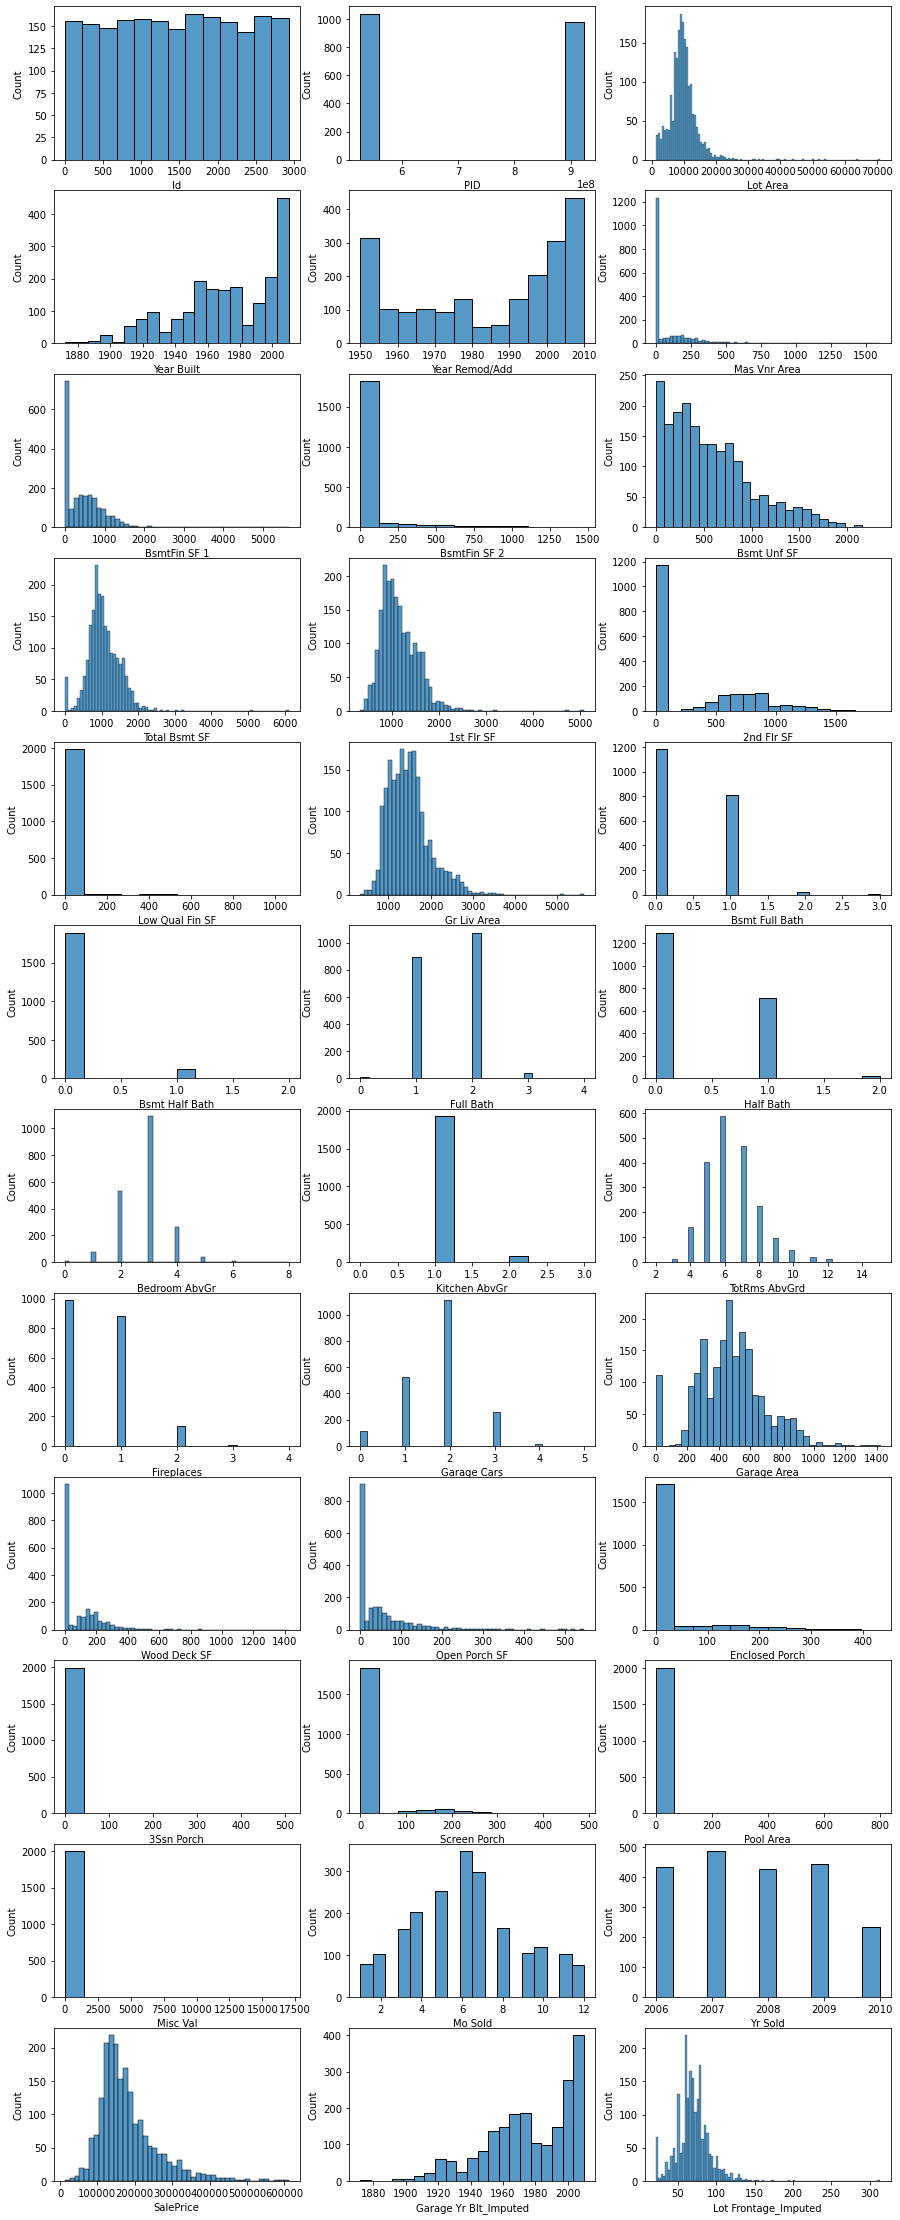

In [91]:
# Checking which feature is not roughly approximate normal distribution
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(15, 40))
for i in range(len(feature_typeNum)):
    row = int(i/3)
    col = i%3
    sns.histplot(x=data[feature_typeNum[i]], ax=ax[row, col])

- Some features such as Mas Vnr Area, 2nd Flr SF, etc showing high counts of 0.
- Observed multiple features with extreme outliers

#### Engineering new features

In [92]:
# Engineering new numeric features
data['Total SF'] = data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF']
data['Total SF**2'] = (data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF'])**2
data['No Of Bath'] = data['Bsmt Full Bath'] + (data['Bsmt Half Bath']/2) + data['Full Bath'] + (data['Half Bath']/2)
data['Total Porch SF'] = data['Open Porch SF'] + data['Enclosed Porch'] + data['3Ssn Porch'] + data['Screen Porch']
data['Amenities SF'] = data['Pool Area'] + data['Wood Deck SF'] + data['Garage Area']
data['Age_Sold'] = data['Yr Sold'] - data['Year Built']
data['Remod/Add Age_Sold'] = data['Yr Sold'] - data['Year Remod/Add']
data['Gr Liv Area**2'] = data['Gr Liv Area']**2

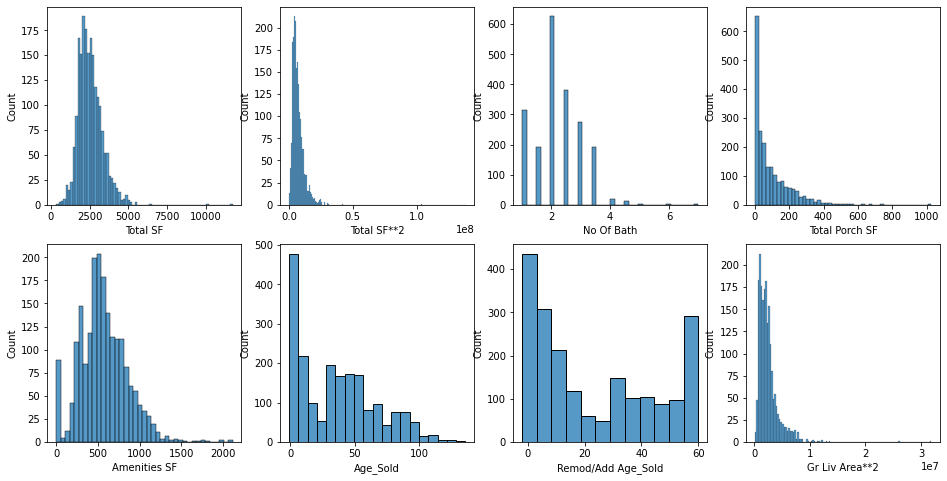

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
engineered_feature = ['Total SF', 'Total SF**2', 'No Of Bath', 'Total Porch SF',
                      'Amenities SF', 'Age_Sold', 'Remod/Add Age_Sold', 'Gr Liv Area**2']
for i in range(len(engineered_feature)):
    row = int(i/4)
    col = i%4
    sns.histplot(x=data[engineered_feature[i]], ax=ax[row, col])

#### Checking impact of Year Built and Year Remod/Add on sale price

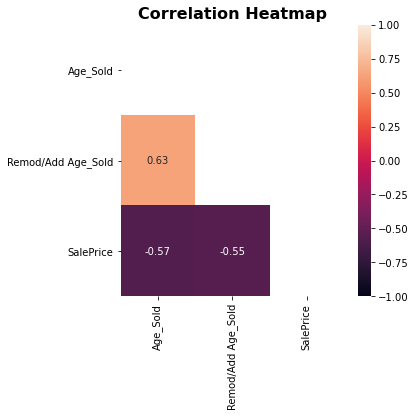

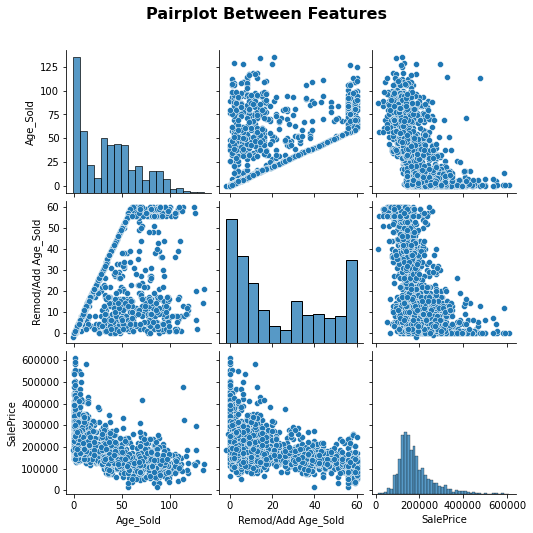

In [94]:
# Plot correlation heatmap between 'Year Built', 'Year Remod/Add', 'SalePrice'
data_interest = data[['Age_Sold', 'Remod/Add Age_Sold', 'SalePrice']]
corr_plots(data_interest, (5,5))

- Medium correlation between 'Age_Sold' and 'Remod/Add Age_Sold'
- All 2 features have similar correlation value to sale price
- To use 'Age_Sold' for model as its distribution is more normally distributed

In [95]:
# Append 'Age_Sold' to list
usable_model_features_list.append('Age_Sold')

#### Checking impact of floor area on sale price

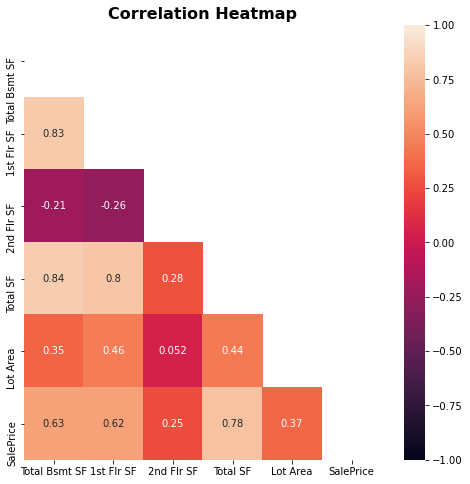

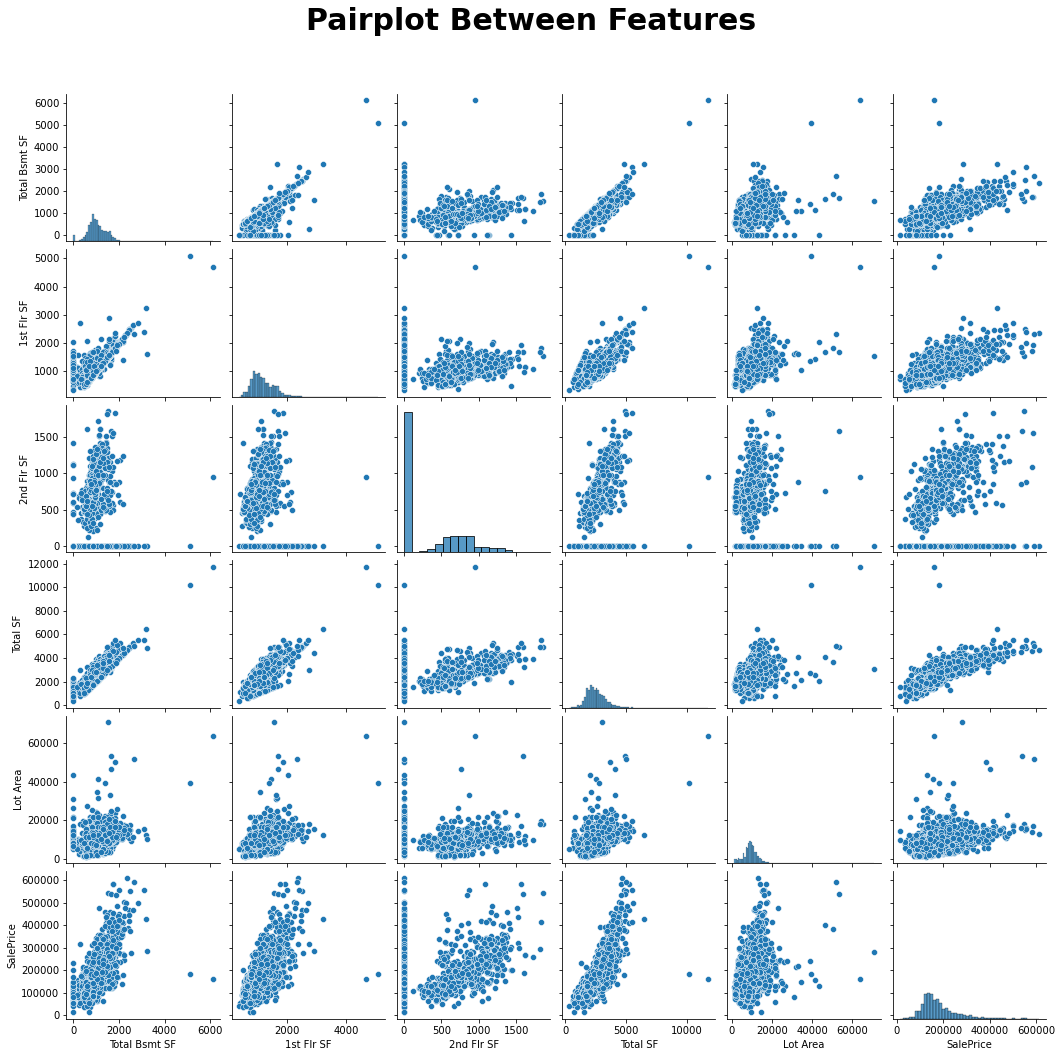

In [96]:
# Plot Pairplot between 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'Lot Area', 'SalePrice' 
data_interest = data[['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'Lot Area', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- Observe 2 outliers for 'Total Bsmt SF', '1st Flr SF', 'Total SF' vs 'SalePrice
- Observe multiple outliers for 'Lot Area' vs 'SalePrice'

In [97]:
# Append 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'Lot Area' to list
usable_model_features_list.extend(['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'Lot Area'])

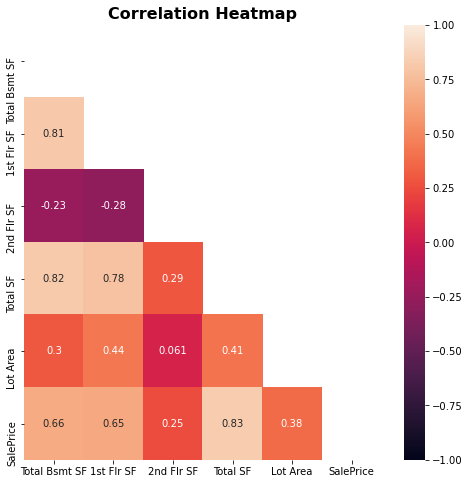

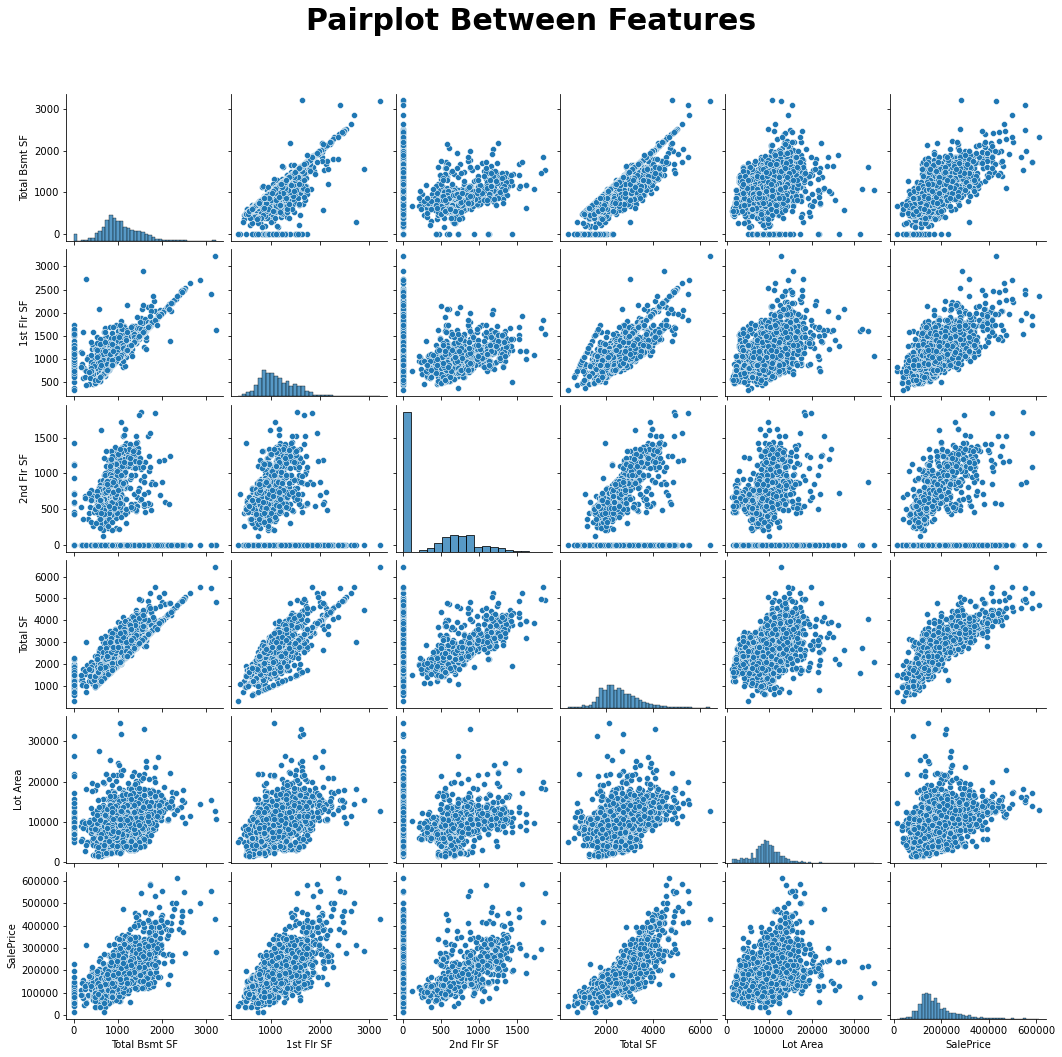

In [98]:
# Replot heatmap and pairplot if exclude outliers
data_filter =  (data['1st Flr SF']<3500) & (data['Lot Area']<35000)
data_interest = data[data_filter][['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF', 'Lot Area', 'SalePrice']]
corr_plots(data_interest, (8,8), 16, 30)

- The correlation coefficients improve slightly for 'Total Bsmt SF', '1st Flr SF' and 'Total SF'

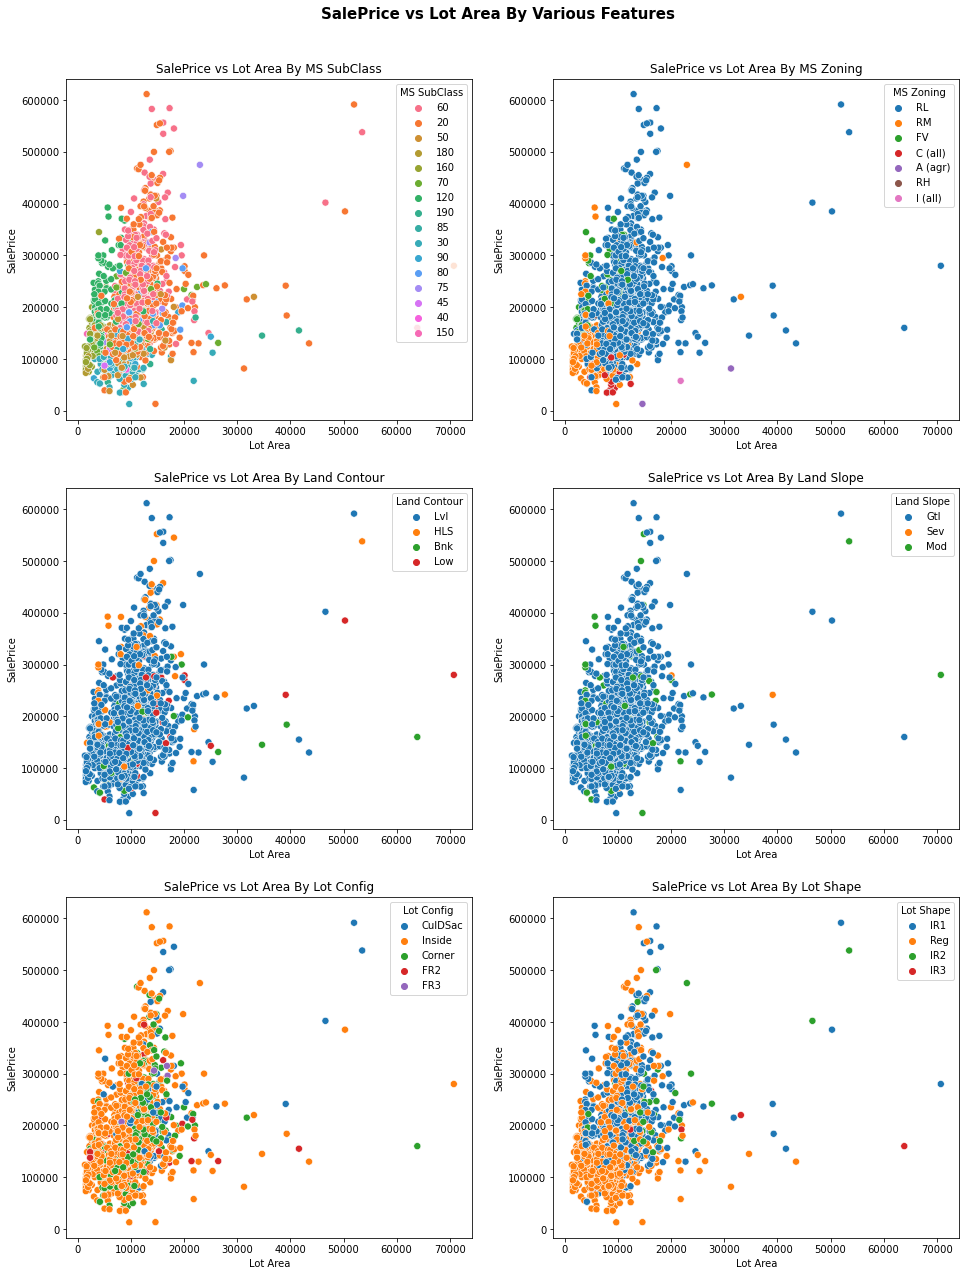

In [99]:
# To find the cause of the outliers observed
features = ['MS SubClass', 'MS Zoning', 'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape']
scatter_plot_3_features(x='Lot Area',
                        y='SalePrice',
                        data=data,
                        features_list = features,
                        rows = 3,
                        cols = 2,
                        figsize=(16, 20),
                        t_fontsize=15,
                        t_dist_top=0.93,
                        marker_size=50)

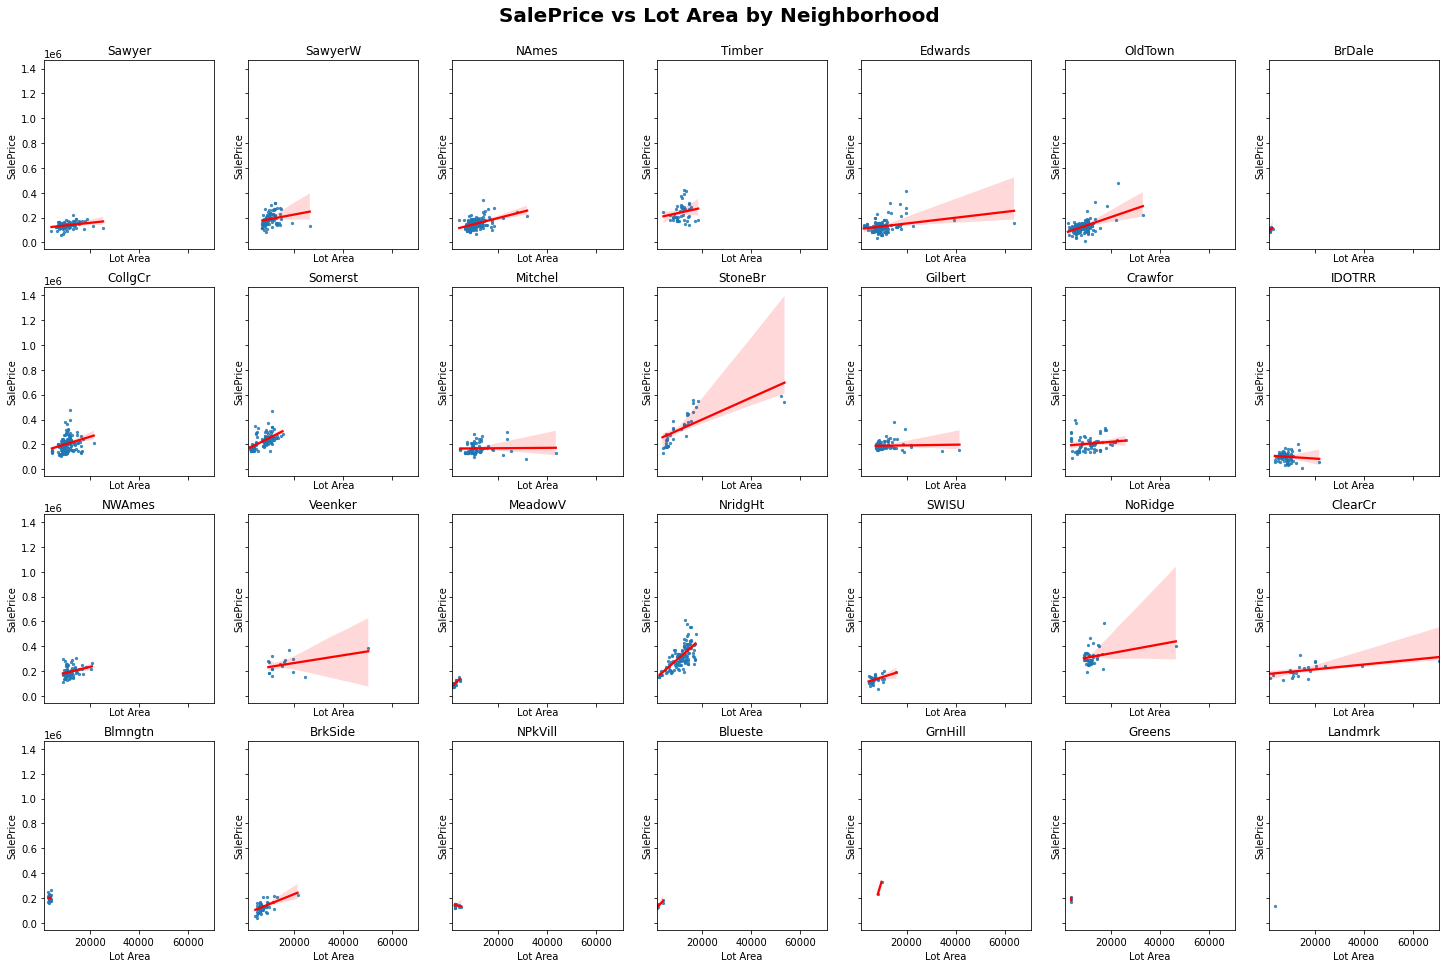

In [100]:
# Scatterplot of SalePrice vs Lot Area by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Lot Area', 
                       y='SalePrice',
                       feature='Neighborhood',
                       rows=4,                        
                       cols=7,
                       figsize=(25,15),
                       t_fontsize=20,
                       t_dist_top=0.93,                   
                       marker_size=5)

- Neighborhood ClearCr is showing non-linear relationship between SalePrice and Lot Area

              Lot Area  Lot Area_log  SalePrice
Lot Area      1.000000      0.900532   0.736241
Lot Area_log  0.900532      1.000000   0.896199
SalePrice     0.736241      0.896199   1.000000


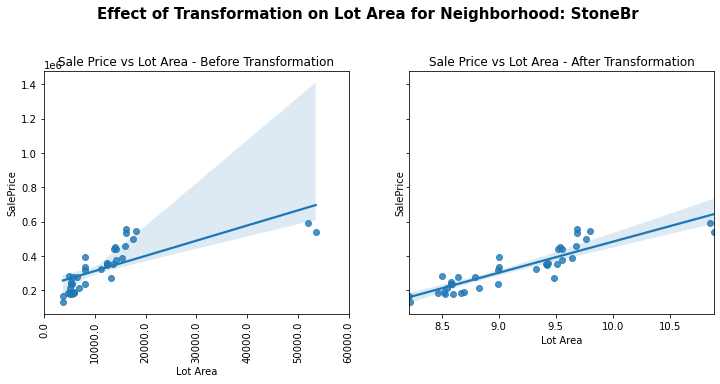

In [101]:
# Check impact of taking log of Lot Area on the correlation coefficient
prePost_logtransform(data=data,
                    x='Lot Area',
                    y='SalePrice',
                    feature='Neighborhood',
                    label='StoneBr',
                    figsize=(12, 5),
                    t_fontsize=15,
                    t_dist_top=0.8)

- Lot Area showing non-linear relationship with SalePrice for StoneBr Neighborhood
- Log of Lot Area helped improve the correlation coefficient with StoneBr neighborhood by 0.16
- To consider interact log(Lot Area) with StoneBr from Neighborhood

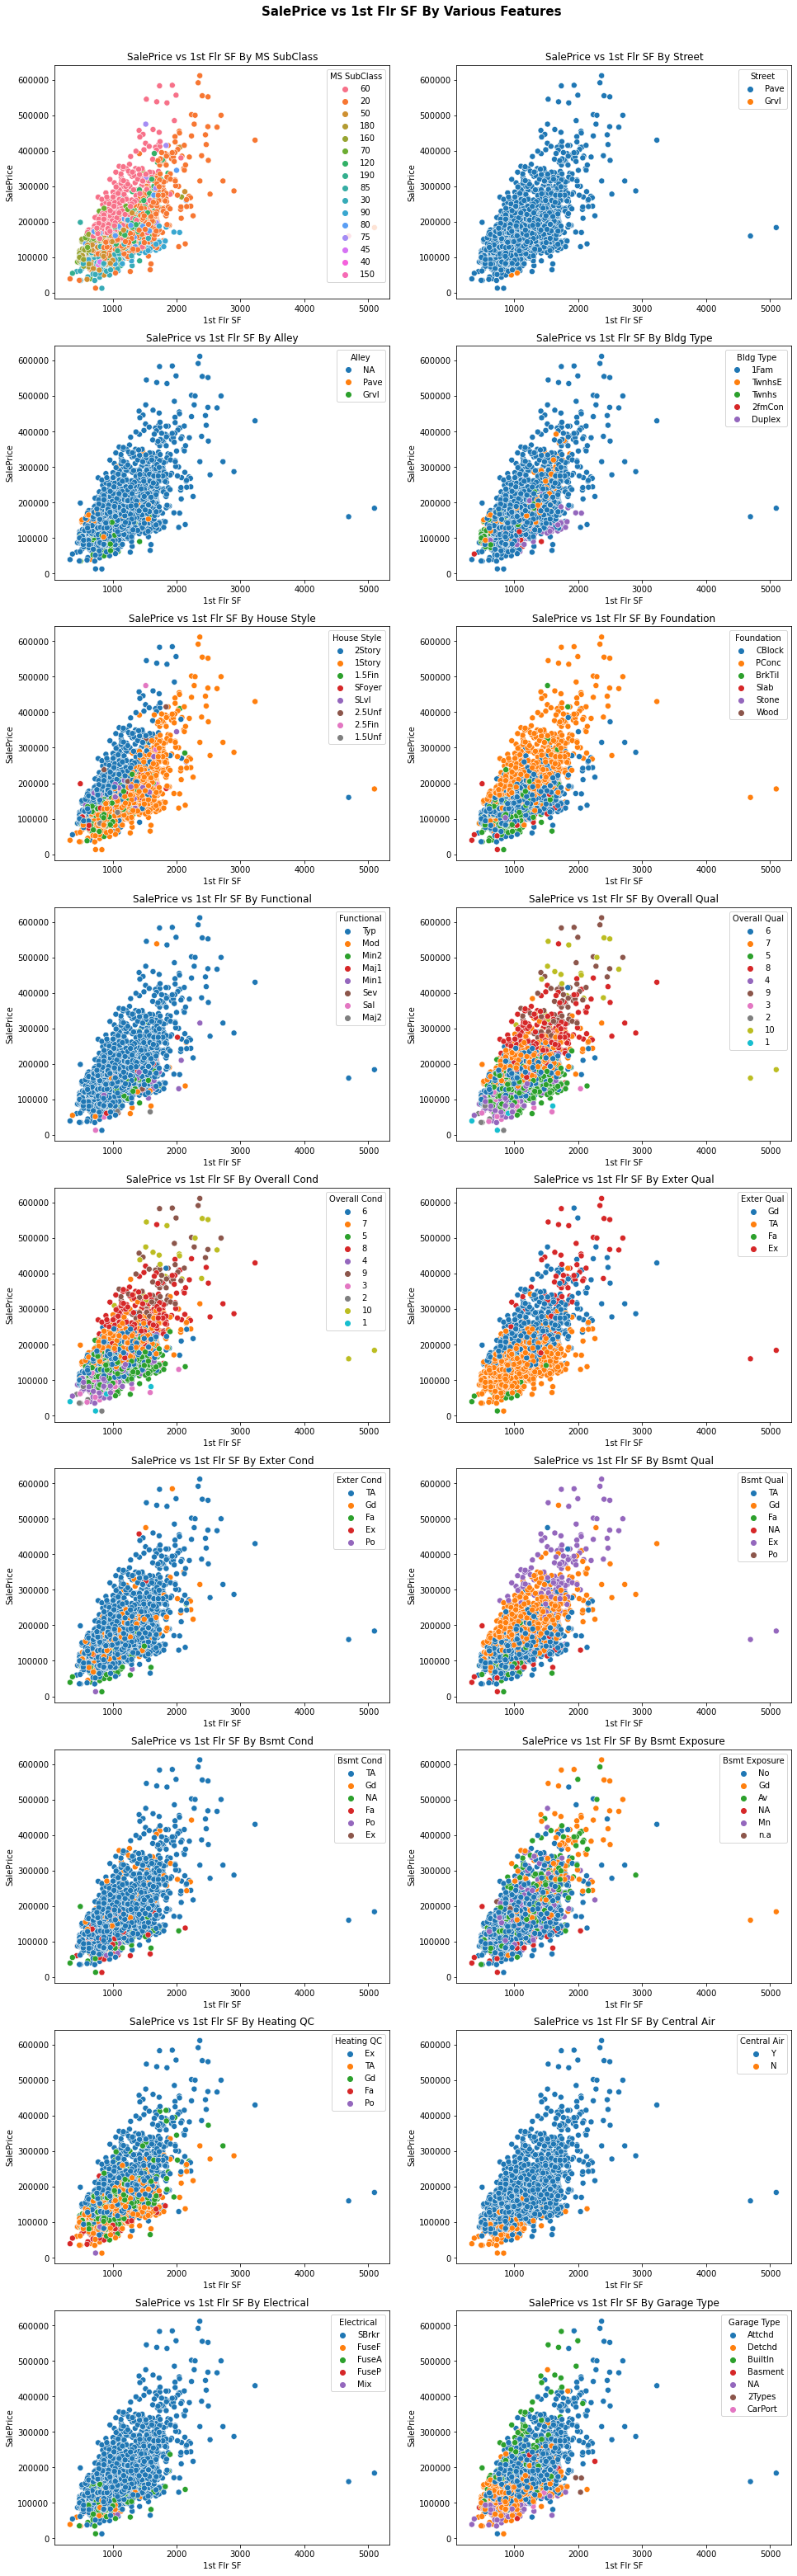

In [102]:
# Scatterplot of SalePrice vs 1st Flr SF by various land-related features with outliers
features = ['MS SubClass', 'Street', 'Alley', 'Bldg Type', 'House Style', 'Foundation', 
            'Functional', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 
            'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Heating QC', 'Central Air', 'Electrical',
           'Garage Type']
scatter_plot_3_features(x='1st Flr SF',
                        y='SalePrice',
                        data=data,
                        features_list = features,
                        rows = 9,
                        cols = 2,
                        figsize=(16, 50),
                        t_fontsize=15,
                        t_dist_top=0.96,
                        marker_size=50)

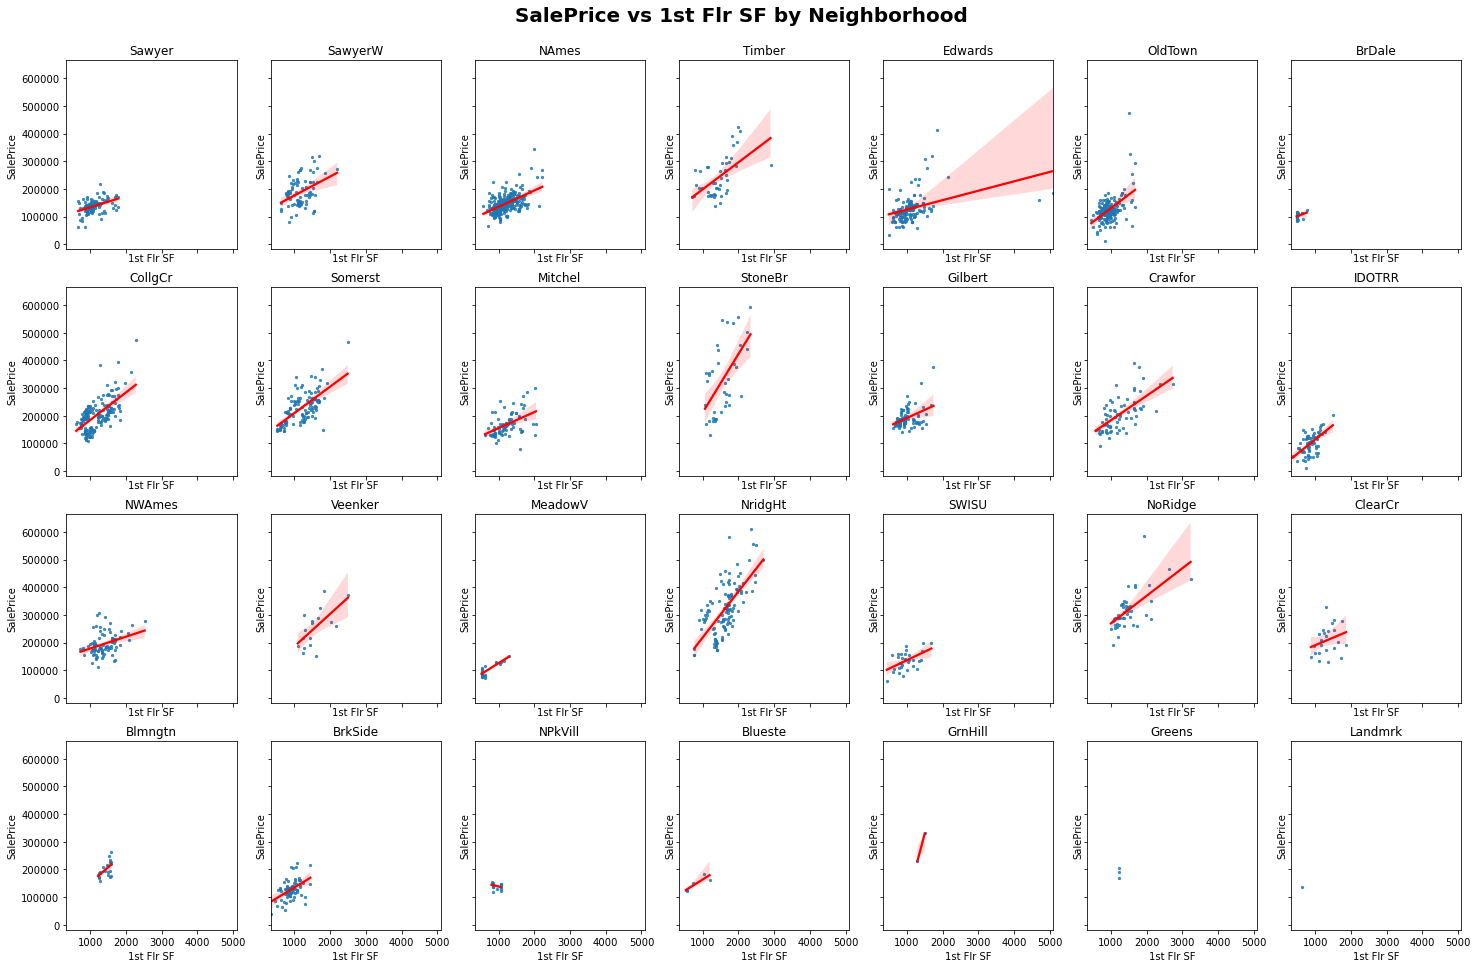

In [103]:
# Scatterplot of SalePrice vs 1st Flr SF by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='1st Flr SF', 
                       y='SalePrice',
                       feature='Neighborhood',
                       rows=4,                        
                       cols=7,
                       figsize=(25,15),
                       t_fontsize=20,
                       t_dist_top=0.93,                   
                       marker_size=5)

- Outliers observed for 1st Flr SF are coming from Neighborhood Edwards

                1st Flr SF  1st Flr SF_log  SalePrice
1st Flr SF        1.000000        0.909791   0.367339
1st Flr SF_log    0.909791        1.000000   0.454630
SalePrice         0.367339        0.454630   1.000000


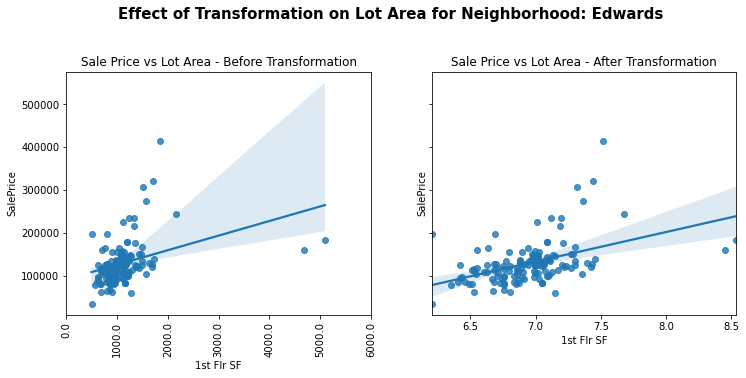

In [104]:
# Comparison of scatter plot before and after transformation of 1st Flr SF 
# Check impact of log of 1st Flr SF on correlatio coefficients
prePost_logtransform(data=data,
                    x='1st Flr SF',
                    y='SalePrice',
                    feature='Neighborhood',
                    label='Edwards',
                    figsize=(12, 5),
                    t_fontsize=15,
                    t_dist_top=0.8)

- Correlation coefficient improves by 0.9 by taking log of 1st Flr SF

                1st Flr SF  1st Flr SF_log  SalePrice
1st Flr SF        1.000000        0.981344   0.528956
1st Flr SF_log    0.981344        1.000000   0.483730
SalePrice         0.528956        0.483730   1.000000


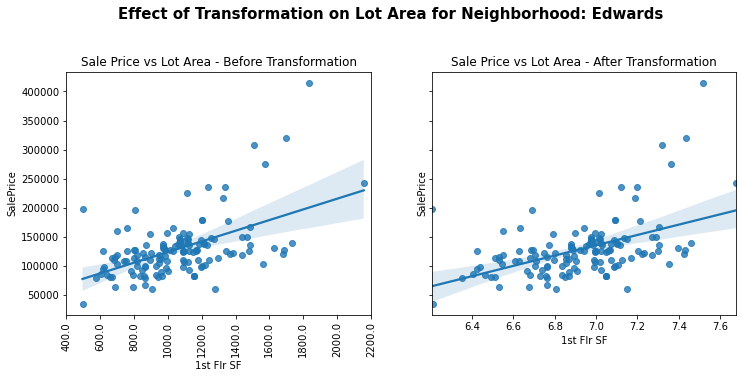

In [105]:
# Comparison of scatter plot before and after transformation of Lot Area (1st Flr SF < 3500)
# Check impact of log of 1st Flr SF on correlatio coefficients (1st Flr SF < 3500)
prePost_logtransform(data=data[(data['Neighborhood']=='Edwards') & (data['1st Flr SF']<3500)],
                    x='1st Flr SF',
                    y='SalePrice',
                    feature='Neighborhood',
                    label='Edwards',
                    figsize=(12, 5),
                    t_fontsize=15,
                    t_dist_top=0.8)

- Outliers observed in SalePrice vs 1st Flr SF is from Neighborhood Edwards
- By taking log of 1st Flr SF, the correlation coefficient improved by 0.09
- By limiting the 1st Flr SF to below 3500, the correlation coefficient improved by 0.04
    - Due to no assignable cause for the outlier
    - Decide to keep data first and use log of 1st Flr SF first and revisit after looking at model

#### Checking impact of basement size on sale price

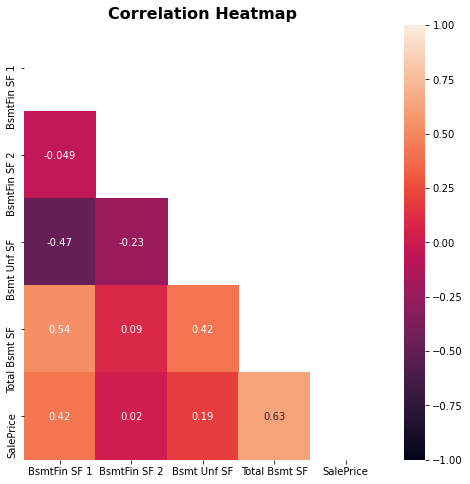

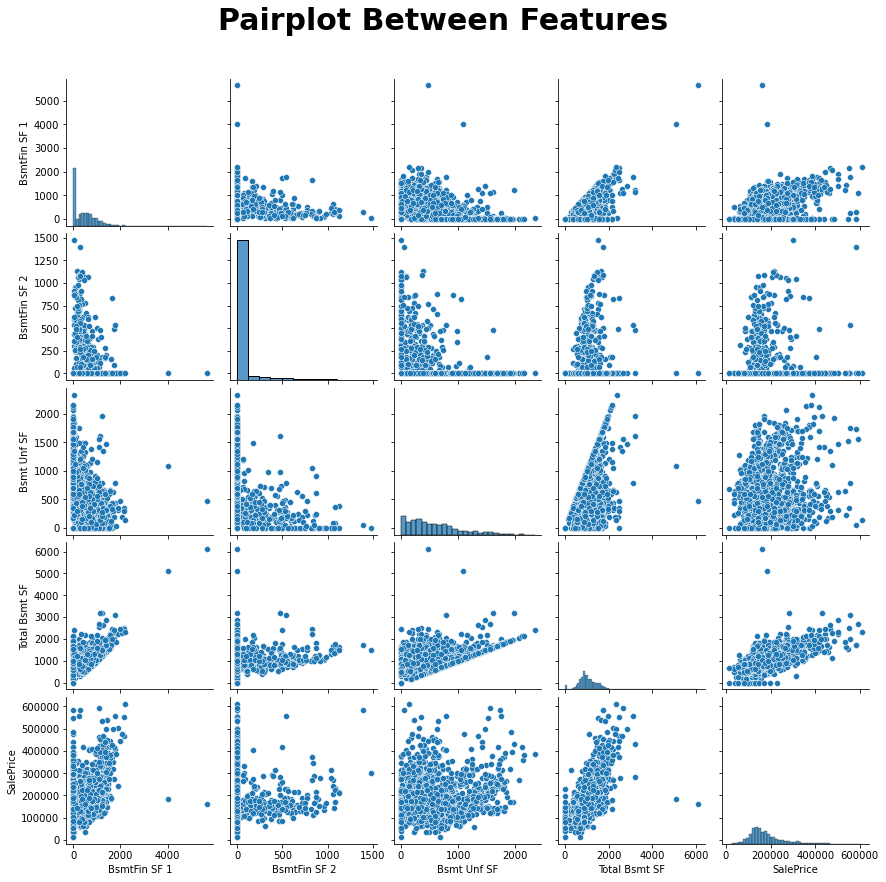

In [106]:
# Plot correlation heatmap between 'BsmtFin SF 1', 'BsmtFin SF 2',
# 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice'
data_interest = data[['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- 'Total Bsmt SF' has better correlation to 'SalePrice' than the other features

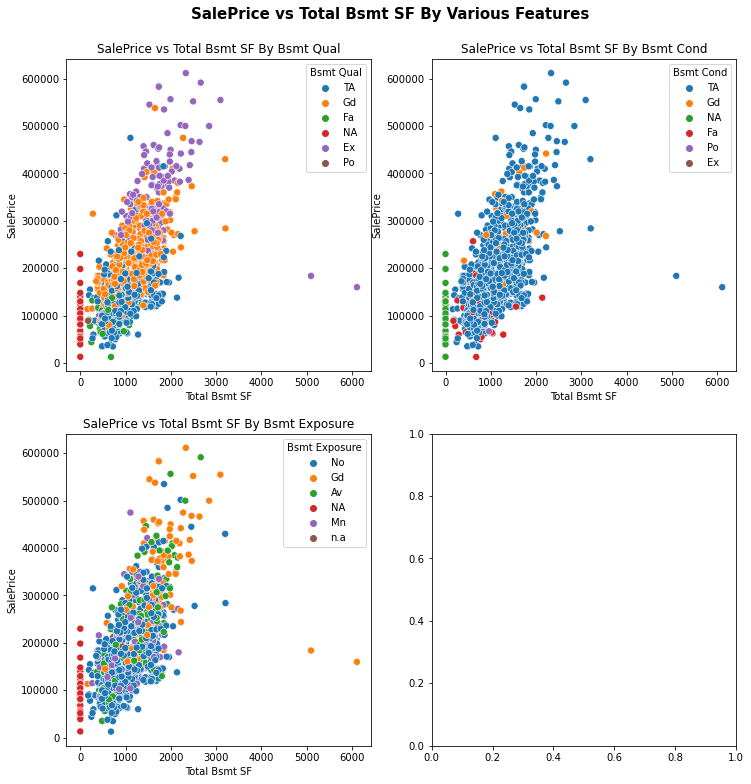

In [107]:
# Scatterplot of SalePrice vs Total Bsmt SF by various land-related features with outliers
features = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure']
scatter_plot_3_features(x='Total Bsmt SF',
                        y='SalePrice',
                        data=data,
                        features_list = features,
                        rows = 2,
                        cols = 2,
                        figsize=(12, 12),
                        t_fontsize=15,
                        t_dist_top=0.92,
                        marker_size=50)

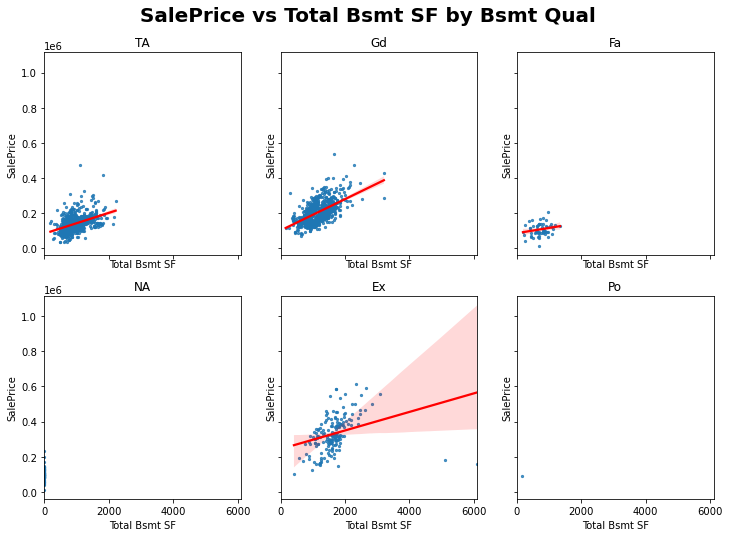

In [108]:
# Scatterplot of SalePrice vs Total Bsmt SF by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Total Bsmt SF', 
                       y='SalePrice',
                       feature='Bsmt Qual',
                       rows=2,                        
                       cols=3,
                       figsize=(12,8),
                       t_fontsize=20,
                       t_dist_top=0.9,                   
                       marker_size=5)

- Outlier causing label 'EX' correlation to be poorer for Bsmt Qual

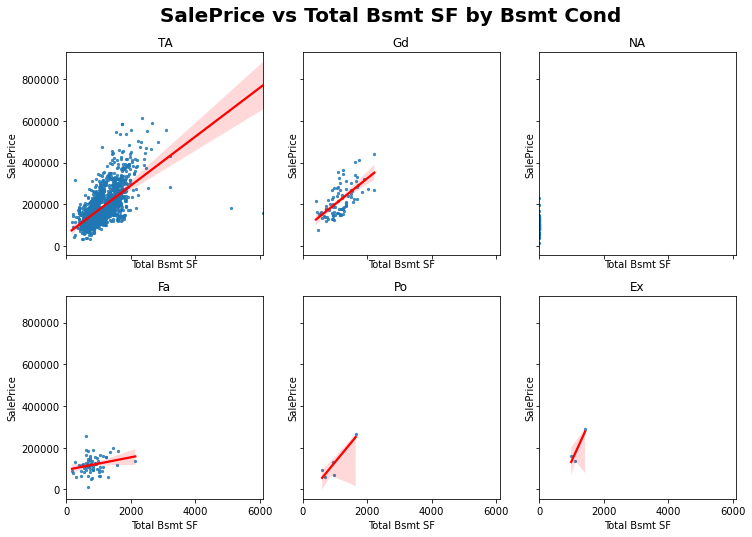

In [109]:
# Scatterplot of SalePrice vs Total Bsmt SF by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Total Bsmt SF', 
                       y='SalePrice',
                       feature='Bsmt Cond',
                       rows=2,                        
                       cols=3,
                       figsize=(12,8),
                       t_fontsize=20,
                       t_dist_top=0.9,                   
                       marker_size=5)

- Outliers did not cause label 'TA' correlation to be poorer for Bsmt Cond

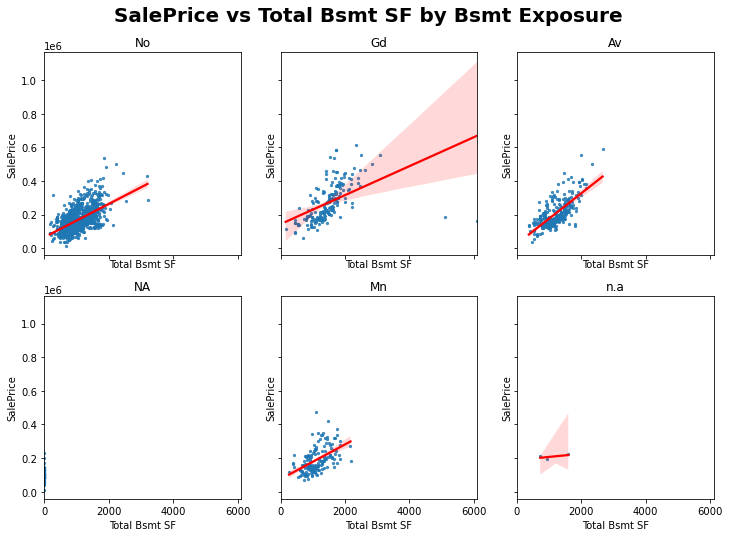

In [110]:
# Scatterplot of SalePrice vs Total Bsmt SF by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Total Bsmt SF', 
                       y='SalePrice',
                       feature='Bsmt Exposure',
                       rows=2,                        
                       cols=3,
                       figsize=(12,8),
                       t_fontsize=20,
                       t_dist_top=0.9,                   
                       marker_size=5)

- Outliers caused label 'Gd' correlation to be poorer for Bsmt Exposure

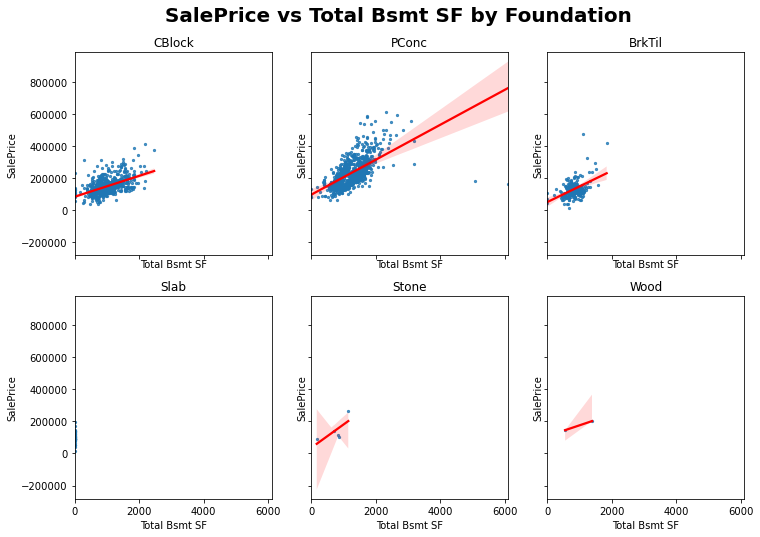

In [111]:
# Scatterplot of SalePrice vs Total Bsmt SF by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Total Bsmt SF', 
                       y='SalePrice',
                       feature='Foundation',
                       rows=2,                        
                       cols=3,
                       figsize=(12,8),
                       t_fontsize=20,
                       t_dist_top=0.9,                   
                       marker_size=5)

- 'Total Bsmt SF' has decent correlation to sale price
- To drop 'BsmtFin SF 1' due to moderate collinearity with 'Total Bsmt SF'
- To drop 'BsmtFin SF 2' & 'Bsmt Unf SF' due to low correlation score

#### Checking impact of  'Mas Vnr Area', 'Low Qual Fin SF' & 'Gr Liv Area' on 'SalePrice'

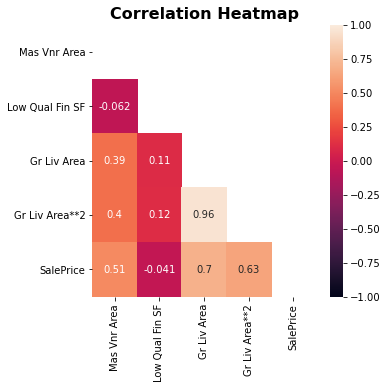

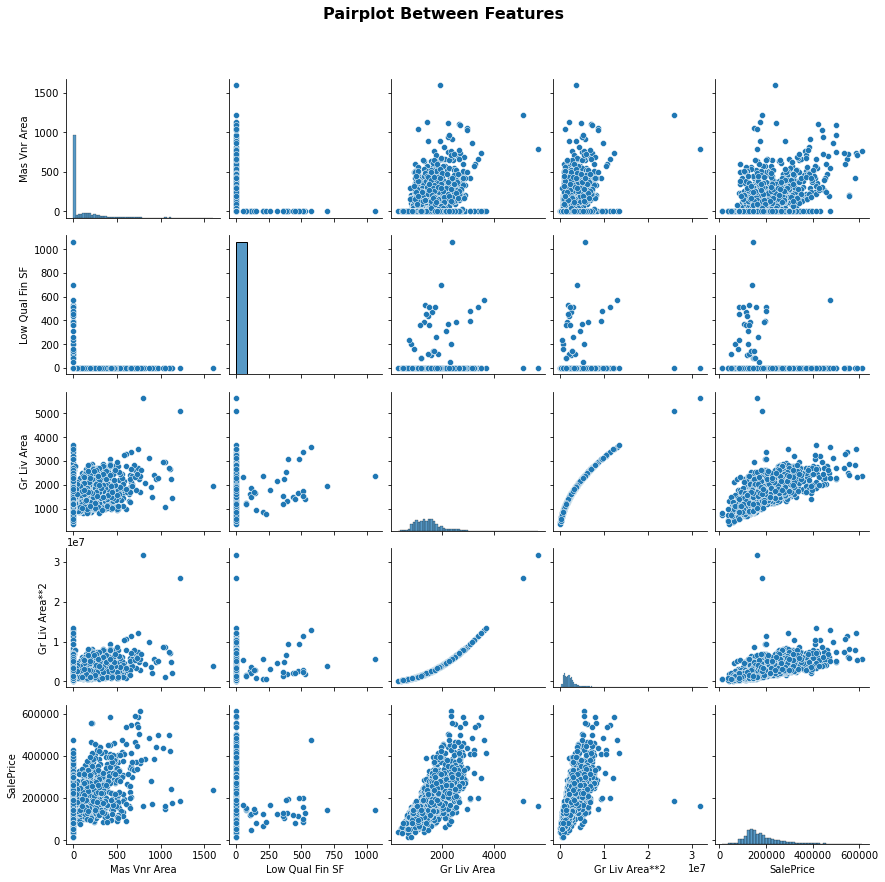

In [112]:
# Plot correlation heatmap between 'Mas Vnr Area', 'Low Qual Fin SF', 'Gr Liv Area', 'SalePrice'
data_interest = data[['Mas Vnr Area', 'Low Qual Fin SF', 'Gr Liv Area', 'Gr Liv Area**2', 'SalePrice']]
corr_plots(data_interest, (5,5))

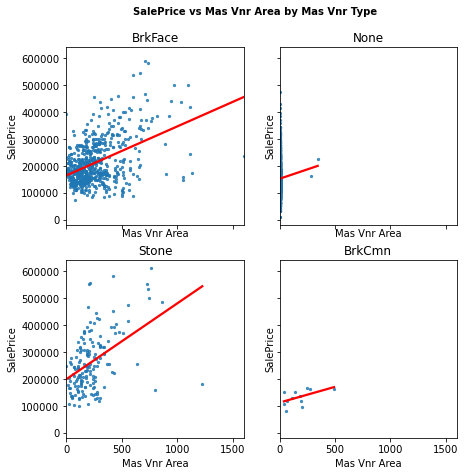

In [113]:
# Scatterplot of SalePrice vs Total Bsmt SF by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Mas Vnr Area', 
                       y='SalePrice',
                       feature='Mas Vnr Type',
                       rows=2,                        
                       cols=2,
                       figsize=(7,7),
                       t_fontsize=10,
                       t_dist_top=0.9,                   
                       marker_size=5,
                       ci=None)

- 'Mas Vnr Area' to be used for modeling for decent correlation score to 'SalePrice'

In [114]:
# Append 'Mas Vnr Area' to list
usable_model_features_list.append('Mas Vnr Area')

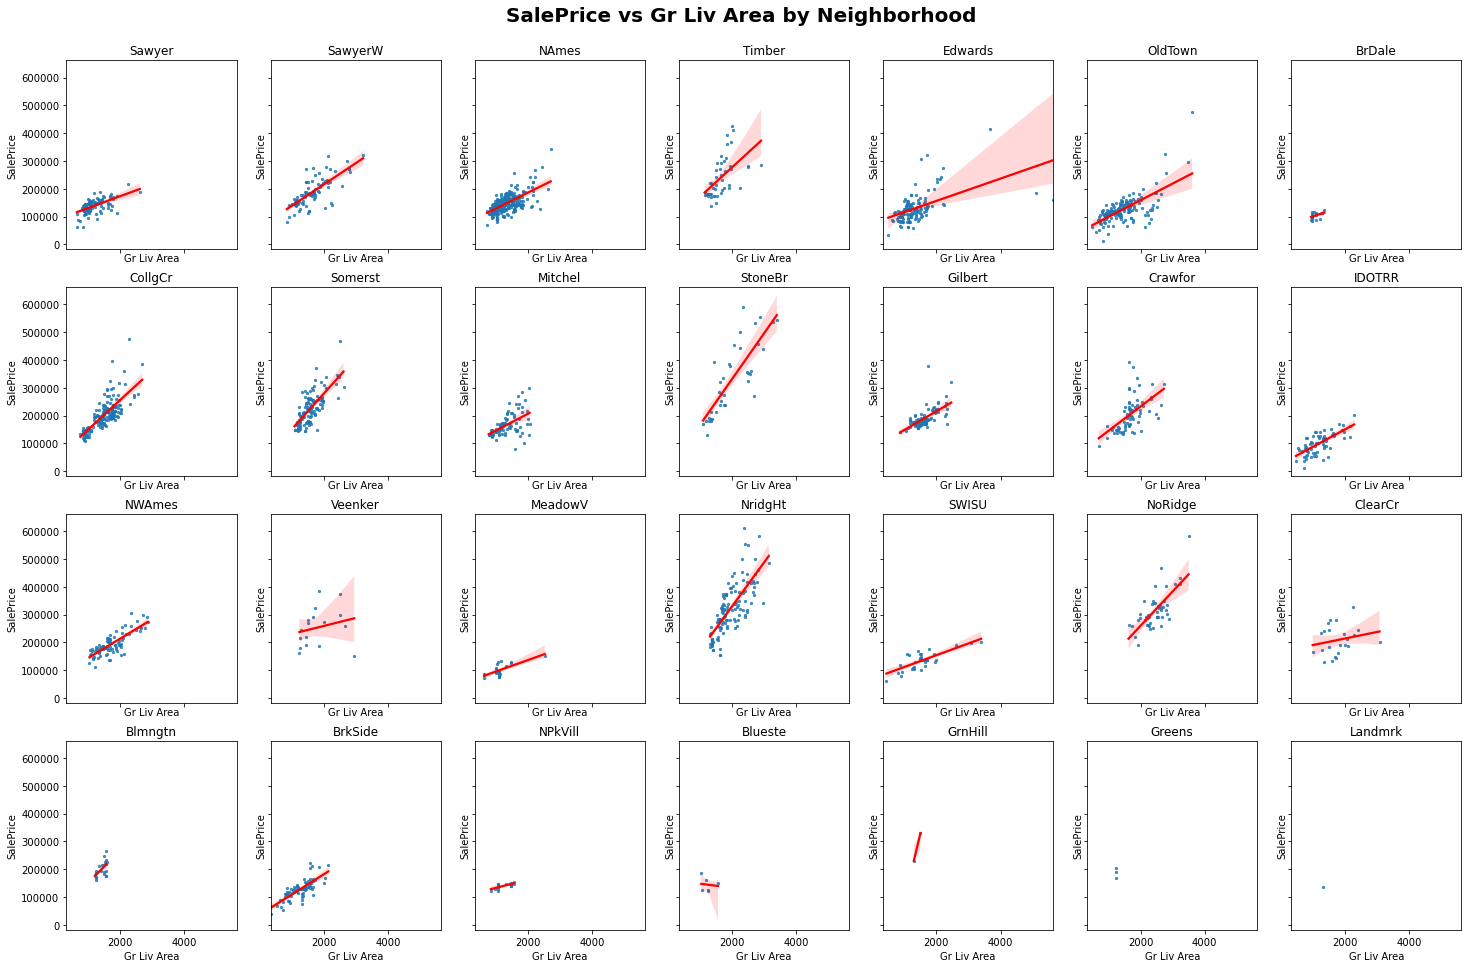

In [115]:
# Scatterplot of SalePrice vs Gr Liv Area by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Gr Liv Area', 
                       y='SalePrice',
                       feature='Neighborhood',
                       rows=4,                        
                       cols=7,
                       figsize=(25,15),
                       t_fontsize=20,
                       t_dist_top=0.93,                   
                       marker_size=5)

                 Gr Liv Area  Gr Liv Area_log  SalePrice
Gr Liv Area         1.000000         0.924235   0.507326
Gr Liv Area_log     0.924235         1.000000   0.577726
SalePrice           0.507326         0.577726   1.000000


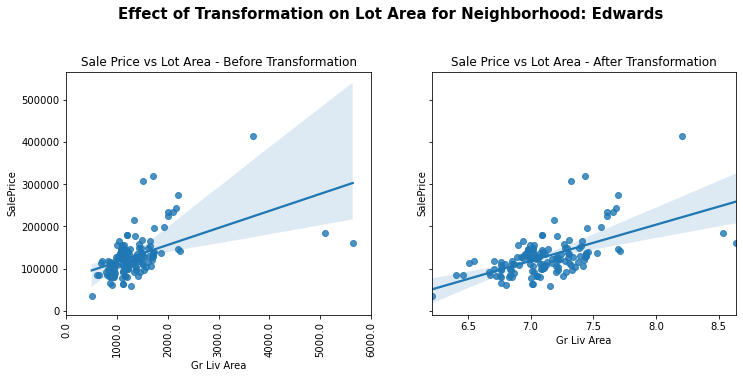

In [116]:
prePost_logtransform(data=data[data['Neighborhood']=='Edwards'],
                    x='Gr Liv Area',
                    y='SalePrice',
                    feature='Neighborhood',
                    label='Edwards',
                    figsize=(12, 5),
                    t_fontsize=15,
                    t_dist_top=0.8)

- Outliers observed in SalePrice vs Gr Liv Area is from Neighborhood Edwards
    - Not surprising since Gr Liv Area and 1st Flr SF is highly correlated to each other
- By taking log of Gr Liv Area, the correlation coefficient improved by 0.07
- To use 'Gr Liv Area' in model due to high correlation score

In [117]:
# Append 'Gr Liv Area', 'Overall Qual' to list
usable_model_features_list.extend(['Gr Liv Area'])

#### Impact of Number of Bathrooms, bedrooms and Kitchen on SalePrice

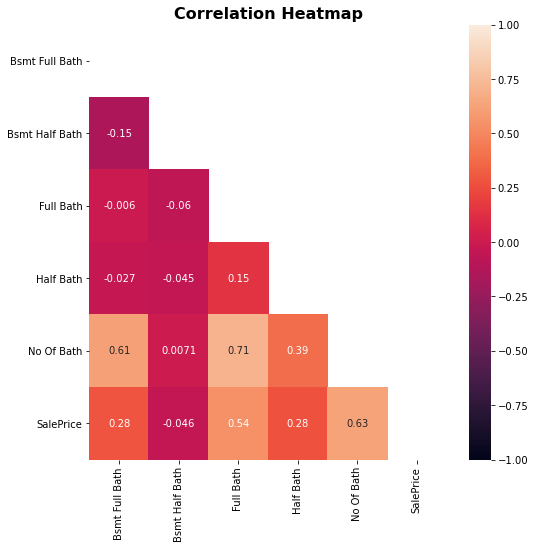

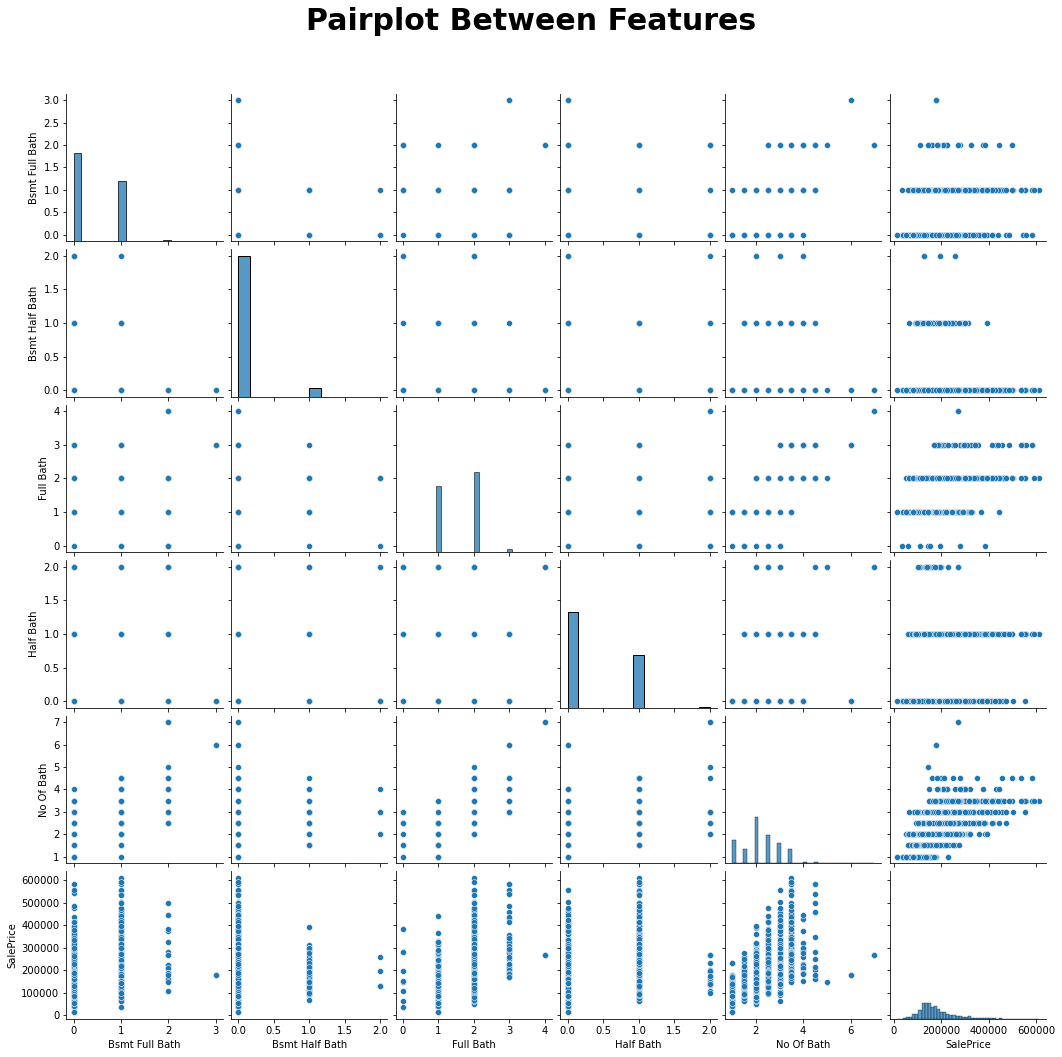

In [118]:
data_interest = data[['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 
                   'No Of Bath', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- Both Full Bath and No of Bath has a good correlation score to SalePrice
- To add both to the list of usable features

In [119]:
# Append 'Full Bath', 'No Of Bath' to list
usable_model_features_list.extend(['Full Bath', 'No Of Bath'])

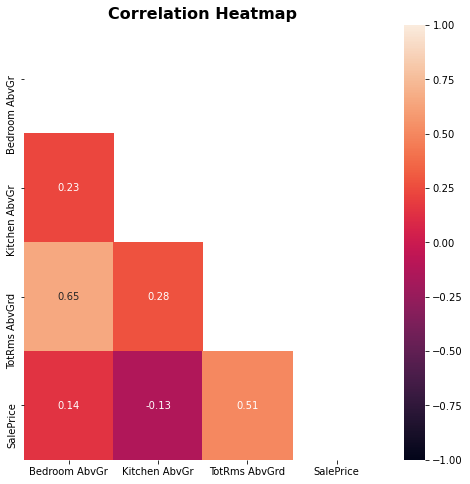

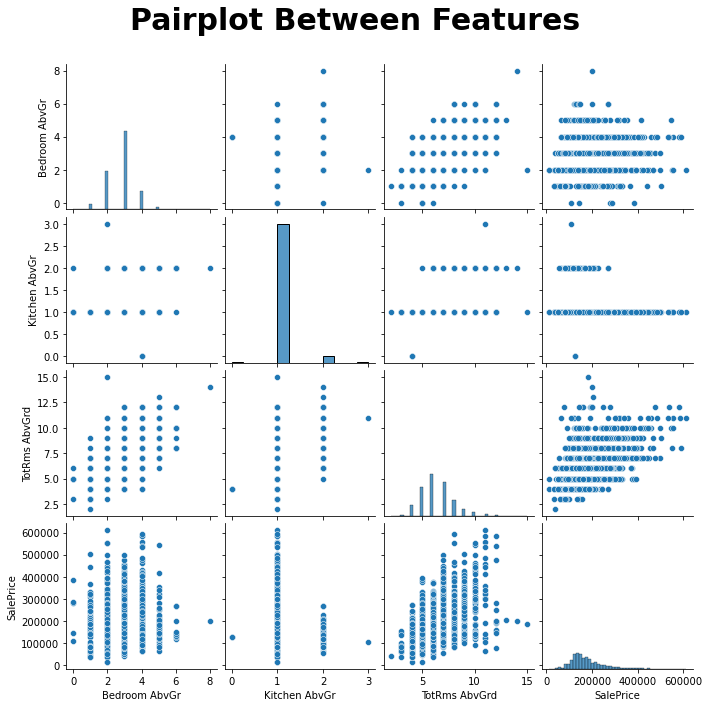

In [120]:
# Looking at Bedrooms, kitchen, Total Room
data_interest = data[['Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- Only TotRms AbvGrd shows decent correlation score
- To add to list

In [121]:
# Append 'Full Bath', 'No Of Bath' to list
usable_model_features_list.extend(['TotRms AbvGrd'])

#### Impact of Garage Cars, Garage Area, Wood Deck SF, Pool Area and Amenities SF on SalePrice

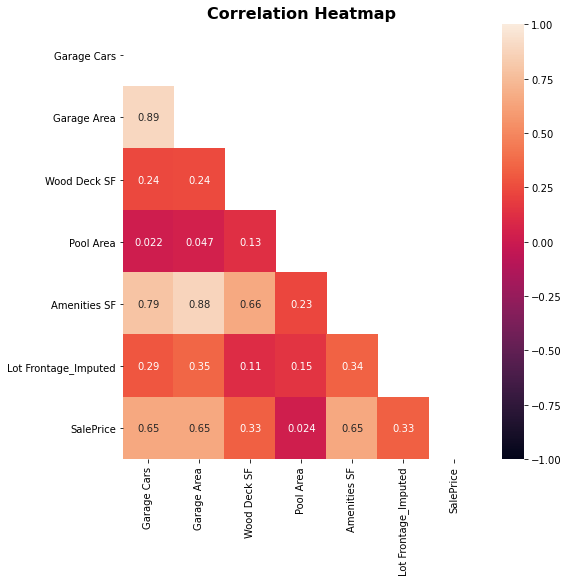

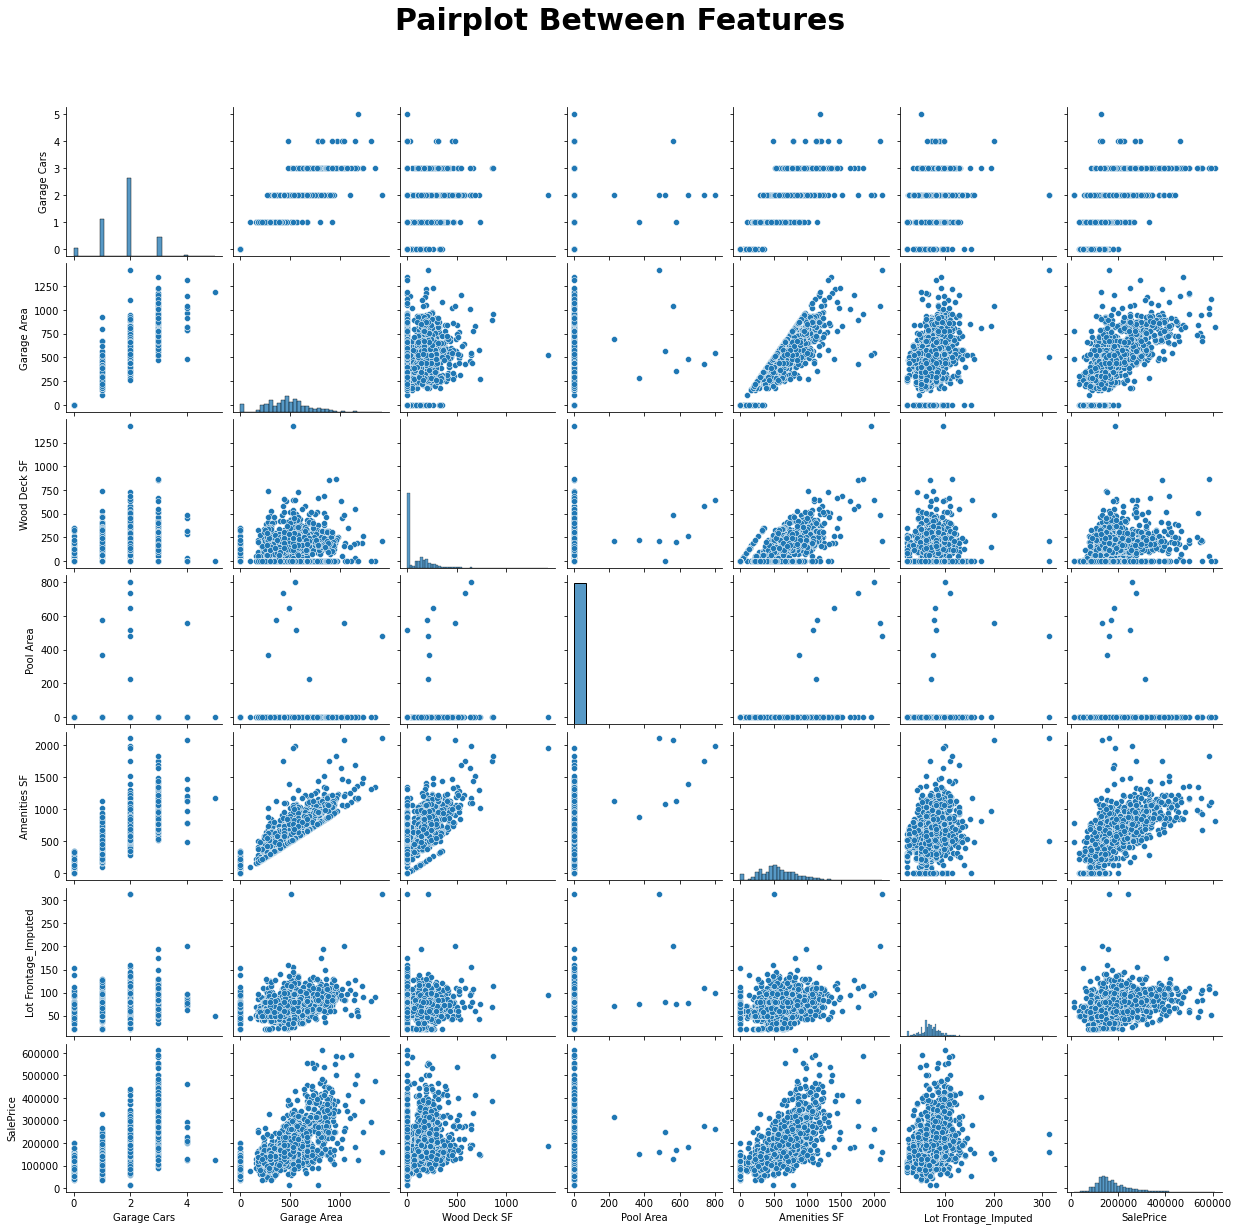

In [122]:
# Looking at 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Pool Area', 'Amenities SF'
data_interest = data[['Garage Cars', 'Garage Area', 'Wood Deck SF', 'Pool Area', 
                      'Amenities SF', 'Lot Frontage_Imputed', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- Garage Cars, Garage Area and Amenities SF has high correlation score
- Lot Frontage_Imputed has a decent to low correlation score but might have been affected by the outliers.

<AxesSubplot:xlabel='Pool Area', ylabel='SalePrice'>

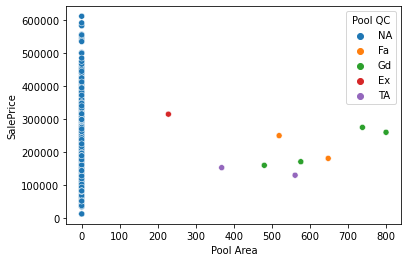

In [123]:
# Pool Area by Pool QC
sns.scatterplot(x='Pool Area', y='SalePrice', hue='Pool QC', data=data)

- Insufficient data point to determine the relationship between Pool Area and Sale Price when grouped by their condition.

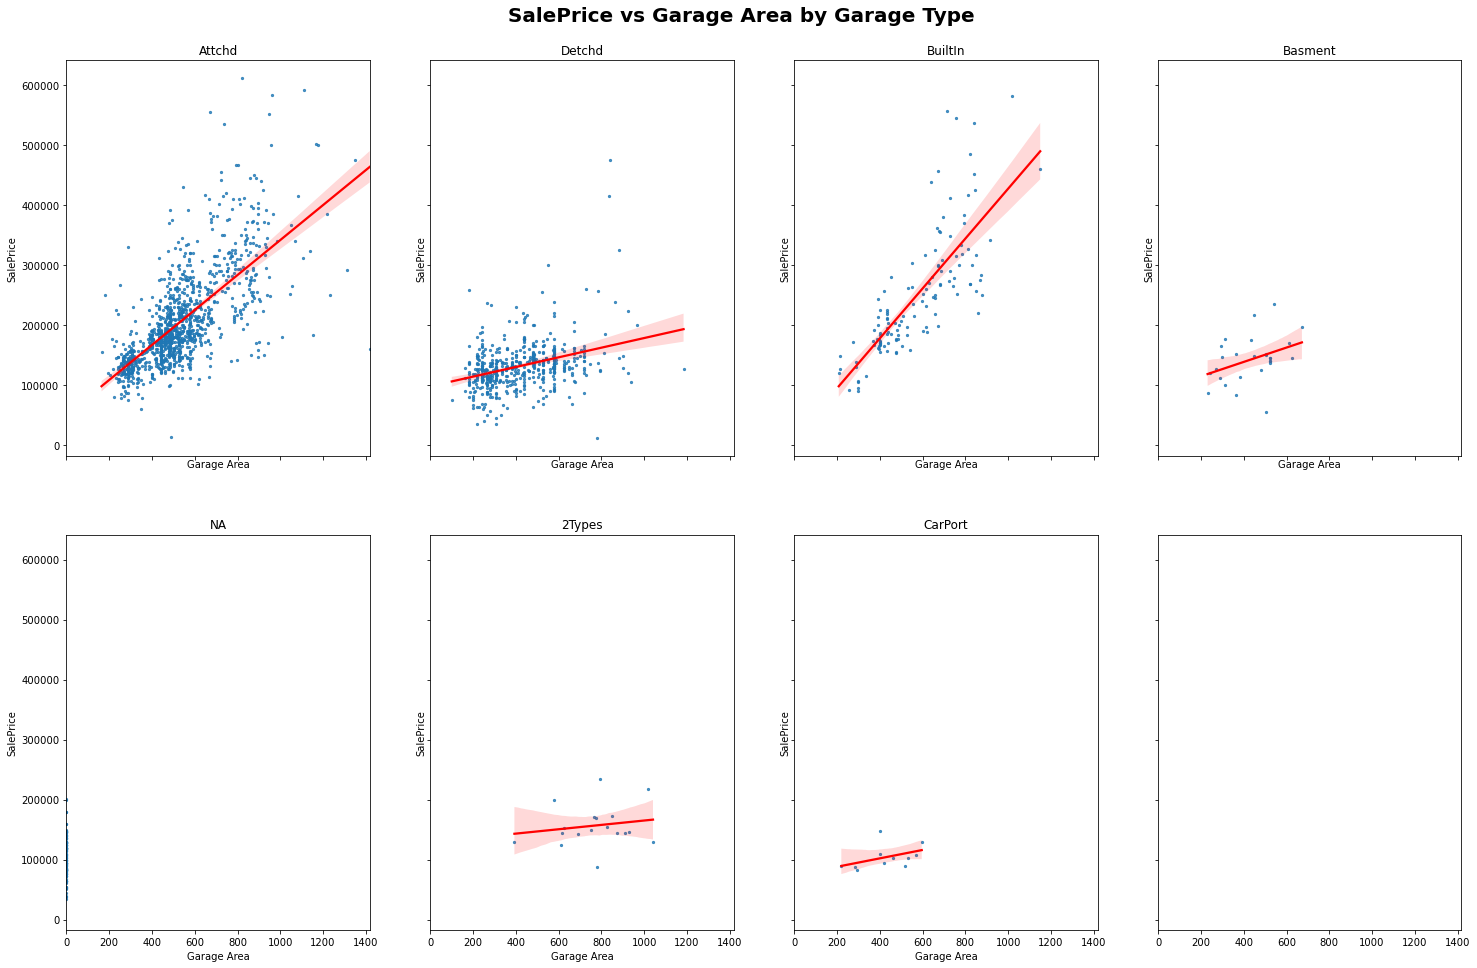

In [124]:
# Scatterplot of SalePrice vs Gr Liv Area by 3rd feature labels
scatter_plot_by_labels(data=data, 
                       x='Garage Area', 
                       y='SalePrice',
                       feature='Garage Type',
                       rows=2,                        
                       cols=4,
                       figsize=(25,15),
                       t_fontsize=20,
                       t_dist_top=0.93,                   
                       marker_size=5)

- To drop 'Garage Cars' in model due to high linearity with 'Garage Area'.
- 'Garage Area' has higher granularity.
- Different garage types scale differently

In [125]:
# Append 'Garage Area', 'Amenities SF' to list
usable_model_features_list.extend(['Garage Area', 'Amenities SF'])

#### Impact of Fireplaces, Misc Val on SalePrice

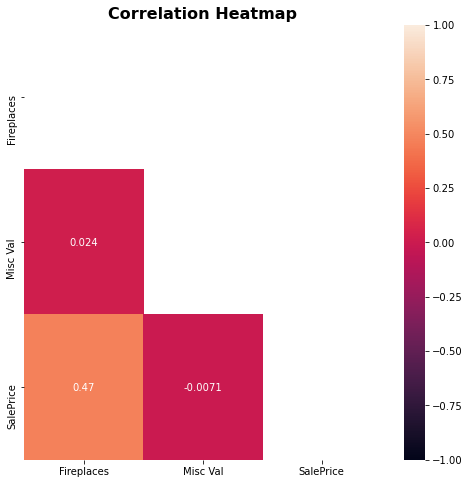

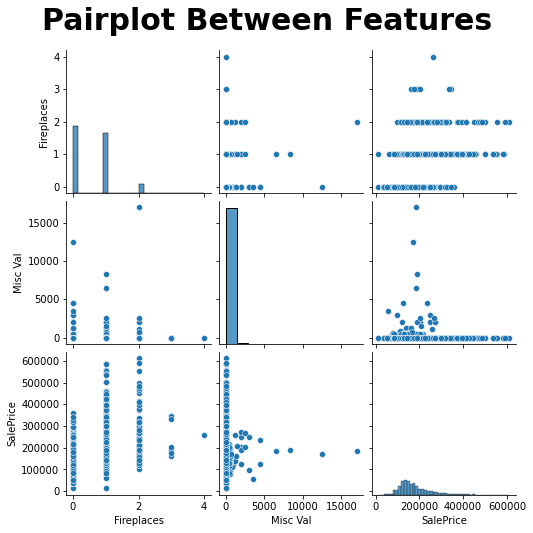

In [126]:
# Looking at 'Fireplaces', 'Misc Val'
data_interest = data[['Fireplaces', 'Misc Val', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

<AxesSubplot:xlabel='Misc Feature', ylabel='Misc Val'>

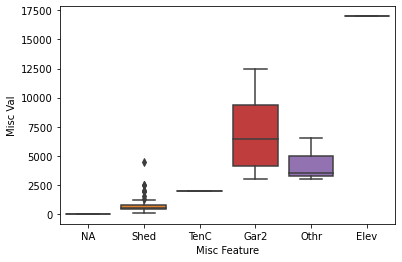

In [127]:
# To check how Misc Val varies with Misc Feature
sns.boxplot(x='Misc Feature', y='Misc Val', data=data)

- To add Fireplace to list as wild card despite slightly poorer correlation score

In [128]:
# Append 'Fireplaces', 'Wood Deck SF' to list
usable_model_features_list.extend(['Fireplaces'])

#### Impact of Porch on SalePrice

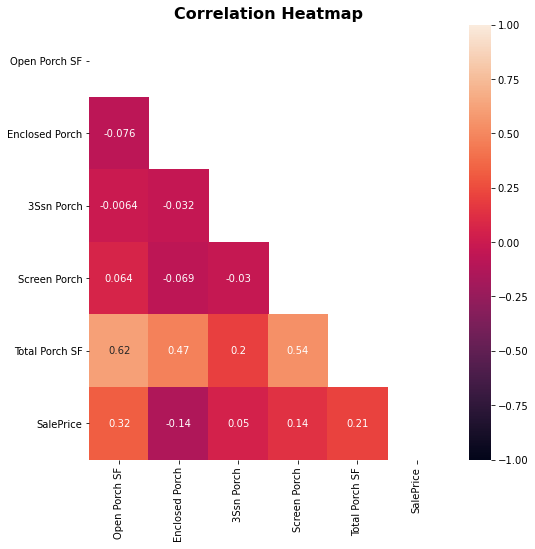

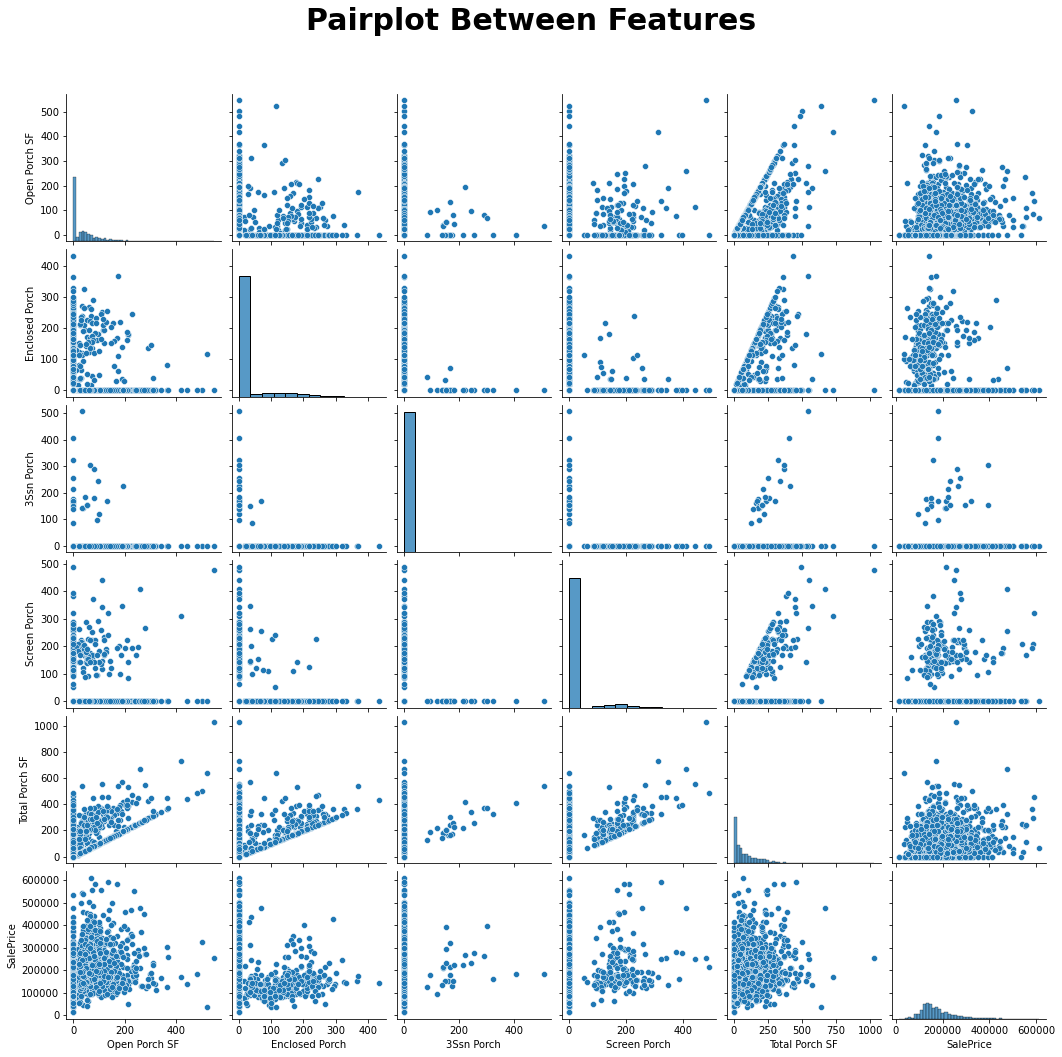

In [129]:
# Looking at 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Total Porch SF' vs 'SalePrice'
data_interest = data[['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 
                      'Total Porch SF', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- Despite porch having a low correlation score, the number of houses without porch might have affected the correlation score.
- To add to list as wild card and let the model decide

In [130]:
# Append 'Open Porch SF', 'Enclosed Porch', 'Screen Porch' to list
usable_model_features_list.extend(['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Total Porch SF'])

#### Impact of Mo Sold and Yr Sold on SalePrice

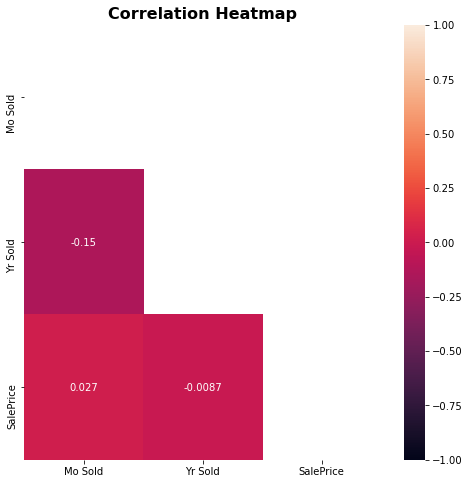

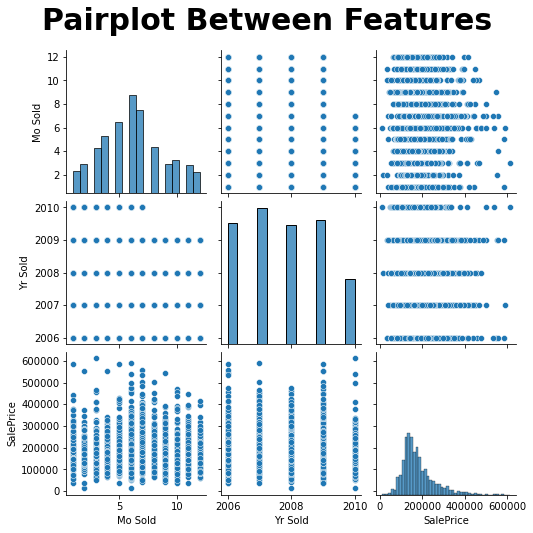

In [131]:
# Looking at Mo Sold and Yr Sold vs 'SalePrice'
data_interest = data[['Mo Sold', 'Yr Sold', 'SalePrice']]
corr_plots(data_interest, (8,8),16, 30)

- To drop 'Mo Sold' and 'Yr Sold' due to low correlation score

#### Checking Impact of Categorical Features on SalePrice

Plotting SalePrice boxplot and counts bar graph for each categorical feature

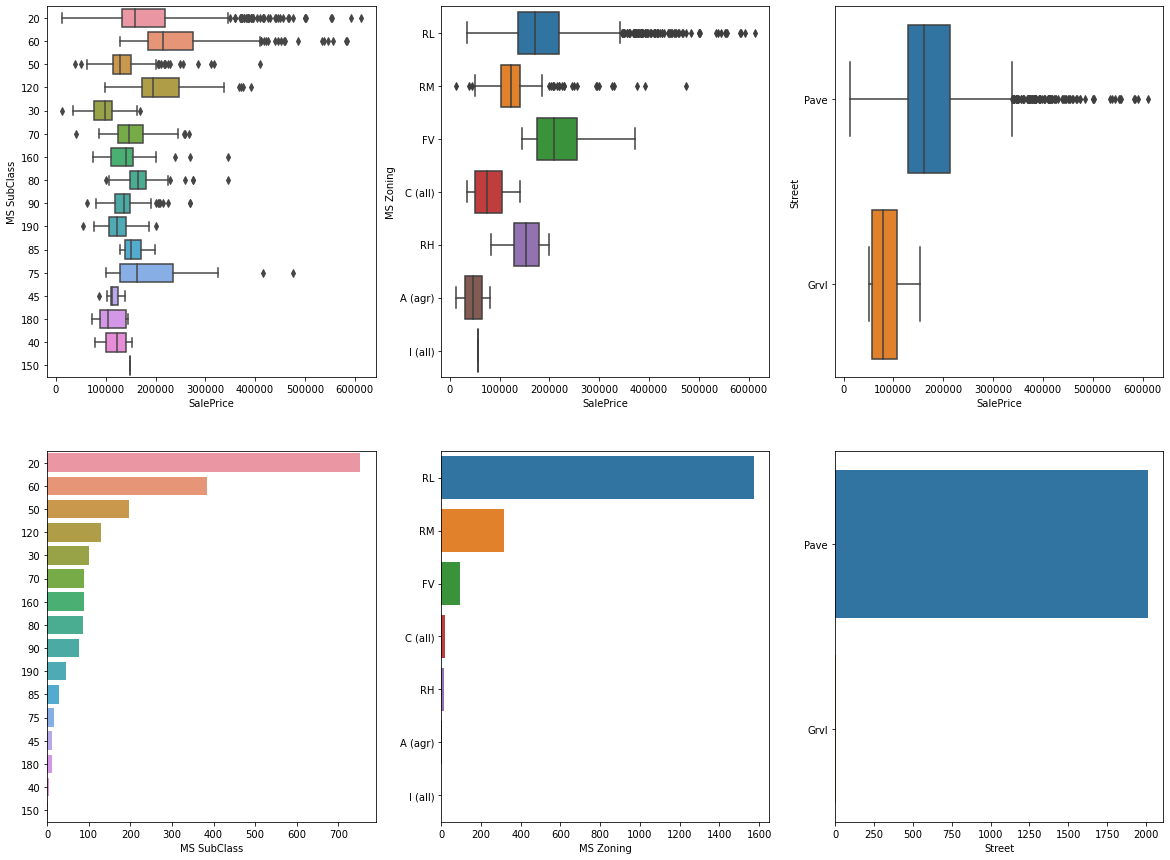

In [132]:
boxplot_count_subplot('SalePrice', ['MS SubClass', 'MS Zoning', 'Street'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use MS SubClass, MS Zoning as primary categorical features as there is a wide spread in the median for each label

In [133]:
usable_model_features_list.extend(['MS SubClass', 'MS Zoning'])

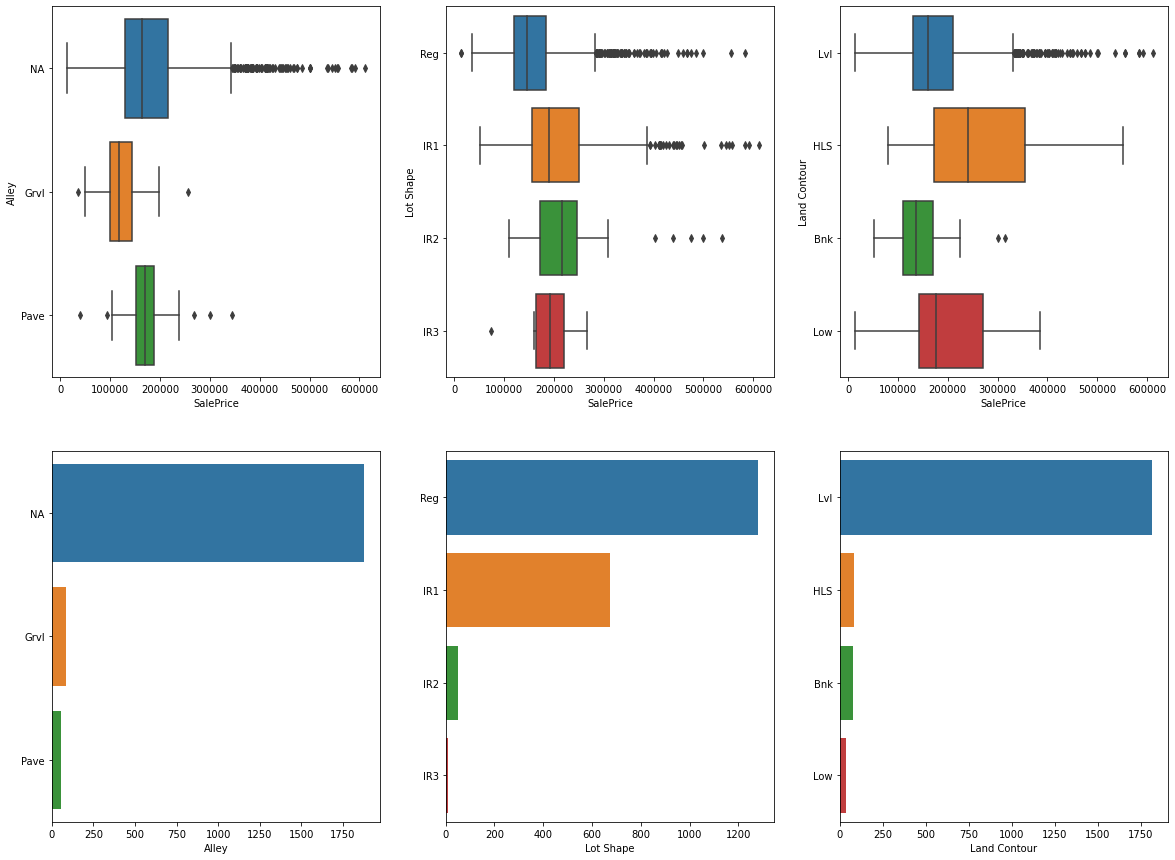

In [134]:
boxplot_count_subplot('SalePrice', ['Alley', 'Lot Shape', 'Land Contour'], data=data, row=2 , col=3, figure_size=(20, 15))

- To use Land Contour as primary feature as there is decent differences between the median of the 4 labels

In [135]:
usable_model_features_list.extend(['Land Contour'])

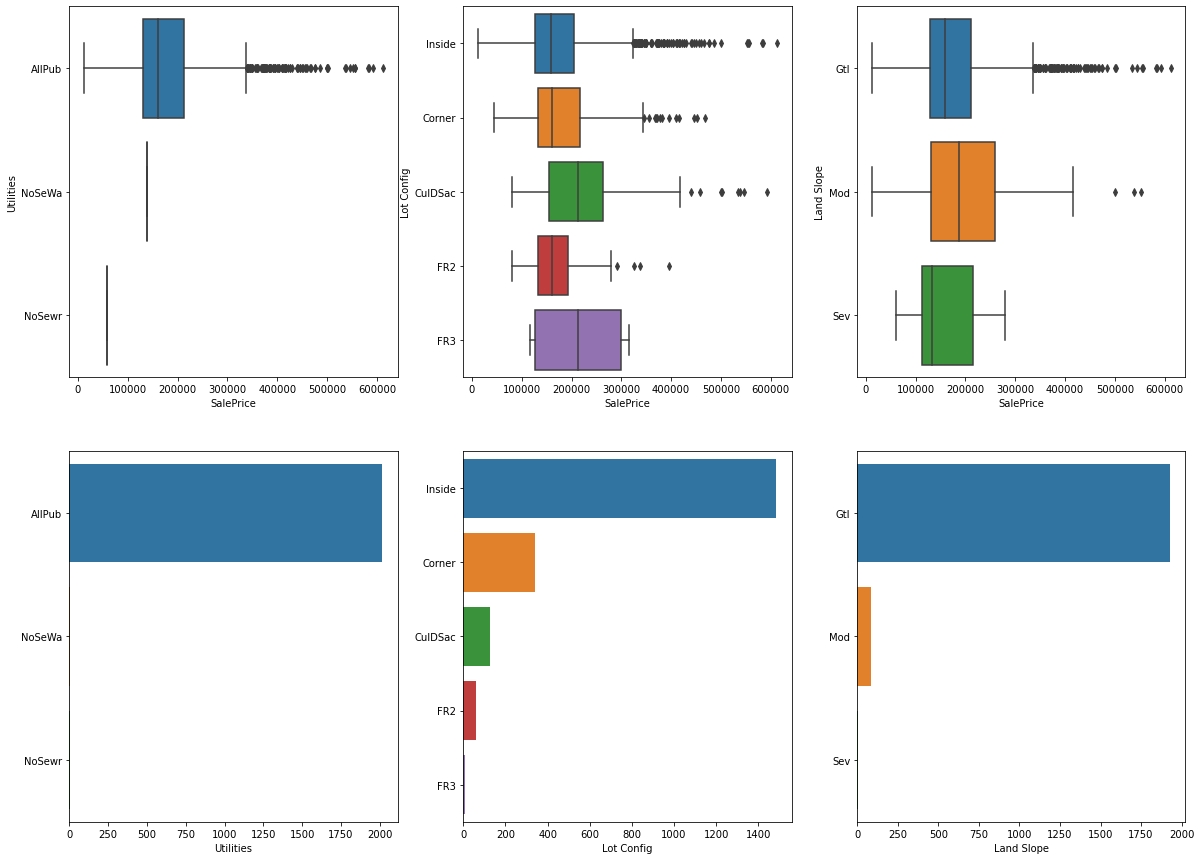

In [136]:
boxplot_count_subplot('SalePrice', ['Utilities', 'Lot Config', 'Land Slope'], data=data, row=2 , col=3, figure_size=(20, 15))

- All 3 categories either have too low counts for other labels or the median of each label does not varies too widely
- To drop all 3 features

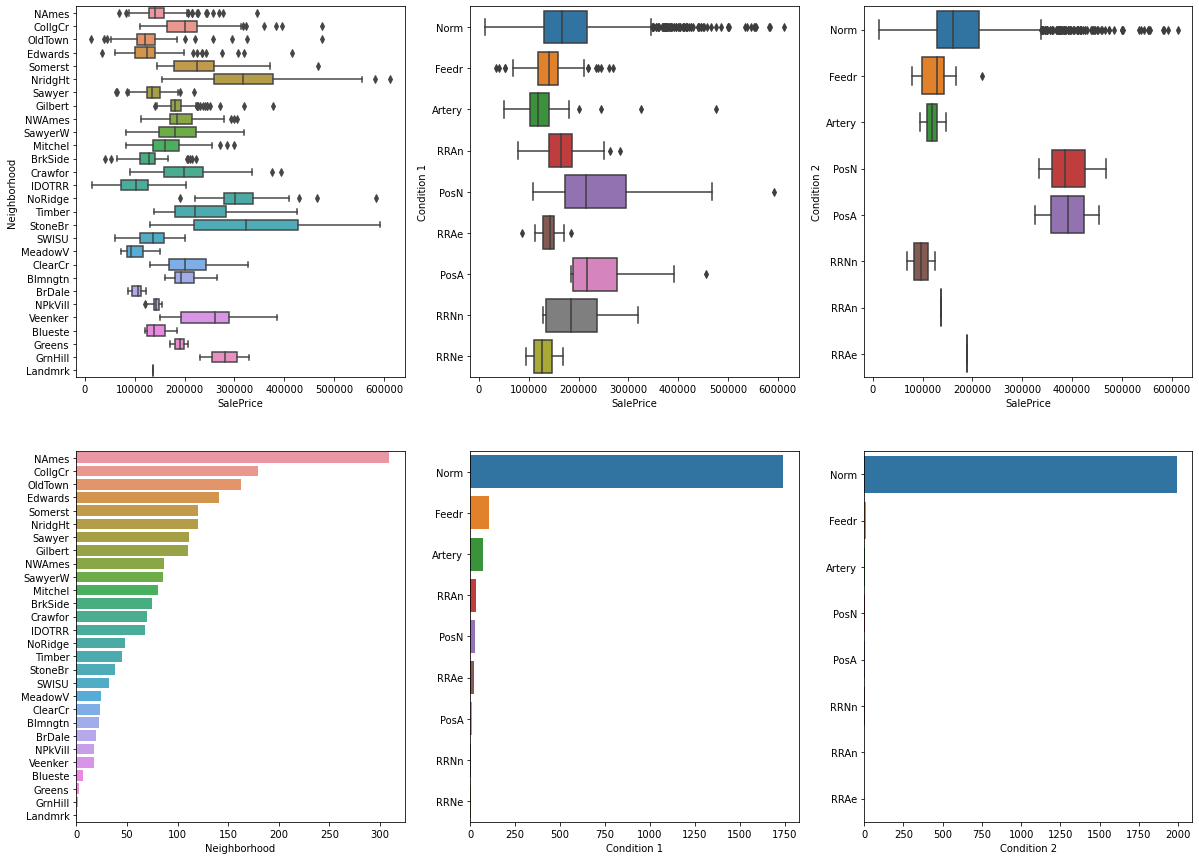

In [137]:
boxplot_count_subplot('SalePrice', ['Neighborhood', 'Condition 1', 'Condition 2'], data=data, row=2 , col=3, figure_size=(20, 15))

- Neighborhood as primary feature as the SalePrice greatlt varies depending on the neighborhood the house is in.
- Condition 1 and 2 has a wide differences in median of each label. However the counts are low for most labels.
- To use all 3 for model to test

In [138]:
usable_model_features_list.extend(['Neighborhood', 'Condition 1', 'Condition 2'])

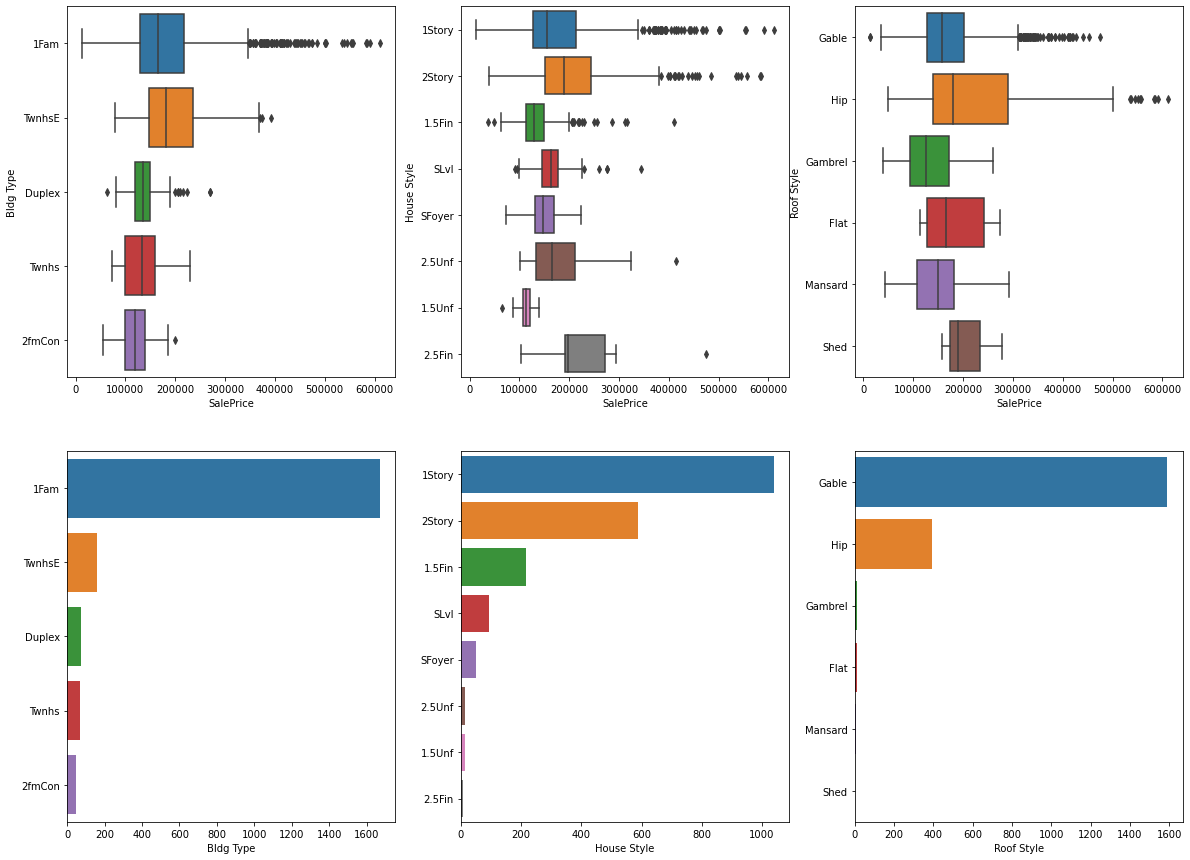

In [139]:
boxplot_count_subplot('SalePrice', ['Bldg Type', 'House Style', 'Roof Style'], data=data, row=2 , col=3, figure_size=(20, 15))

- House Style has a distinct seperation in SalePrice for each category
- To add to list

In [140]:
usable_model_features_list.extend(['House Style'])

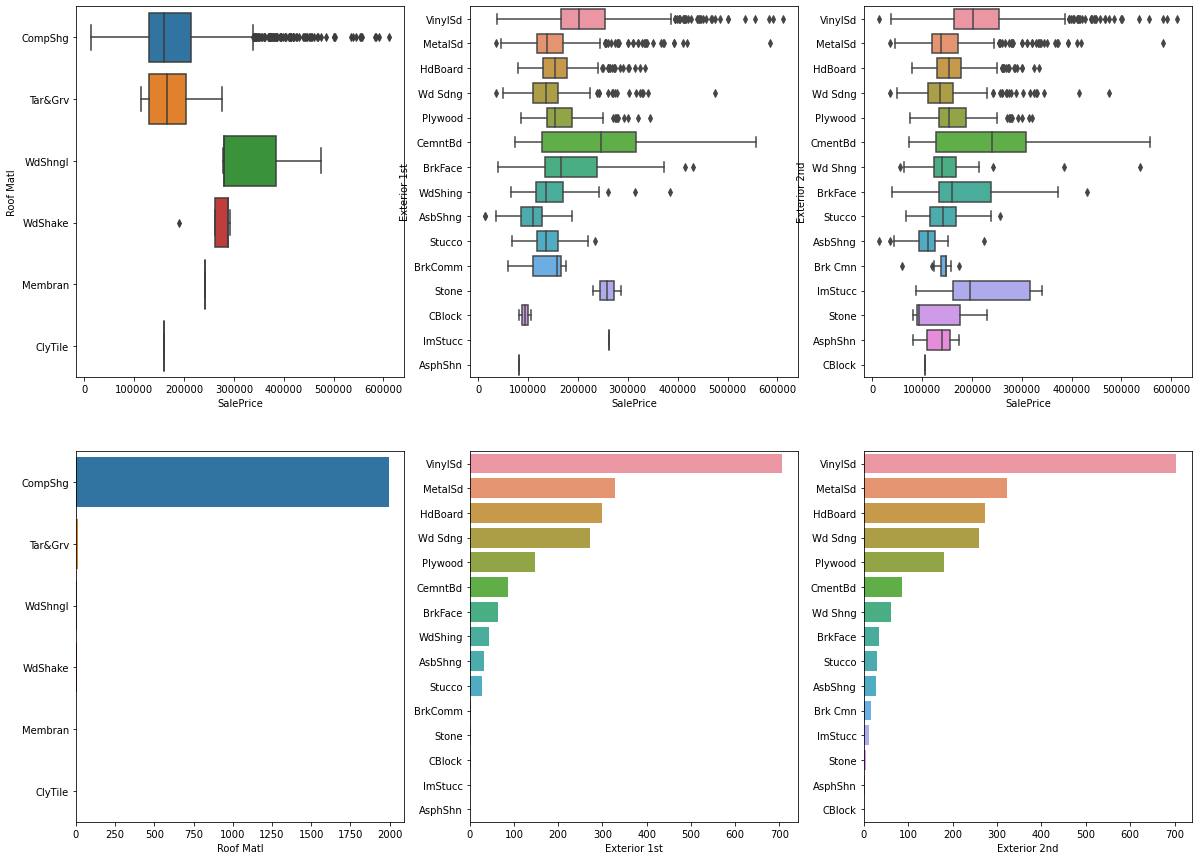

In [141]:
boxplot_count_subplot('SalePrice', ['Roof Matl', 'Exterior 1st', 'Exterior 2nd'], data=data, row=2 , col=3, figure_size=(20, 15))

- Exterior 1st and Exterior 2nd to be added to list due to some cetegories having higher SalePrice

In [142]:
usable_model_features_list.extend(['Exterior 1st', 'Exterior 2nd'])

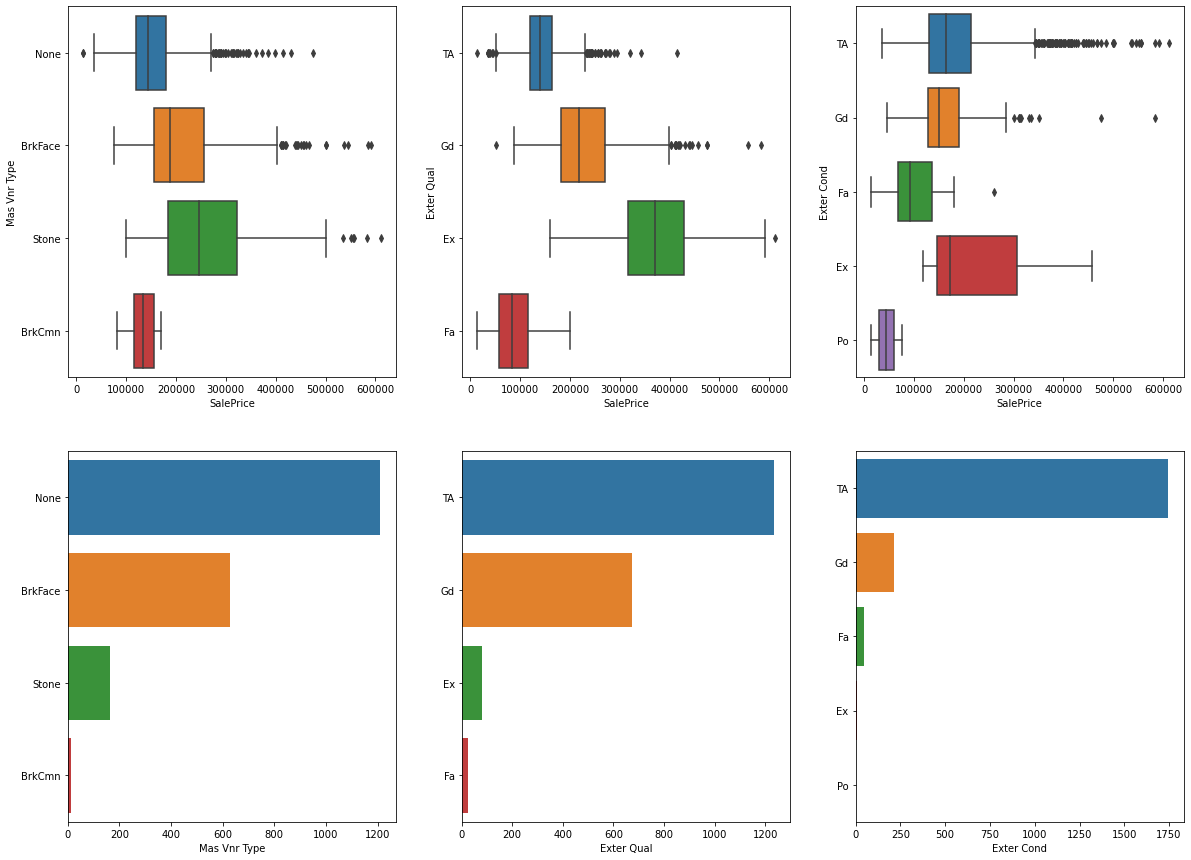

In [143]:
boxplot_count_subplot('SalePrice', ['Mas Vnr Type', 'Exter Qual', 'Exter Cond'], data=data, row=2 , col=3, figure_size=(20, 15))

- Mas Vnr Type and Exter Qual to be incldued in list as SalePrice varies with each category

In [144]:
usable_model_features_list.extend(['Mas Vnr Type', 'Exter Qual'])

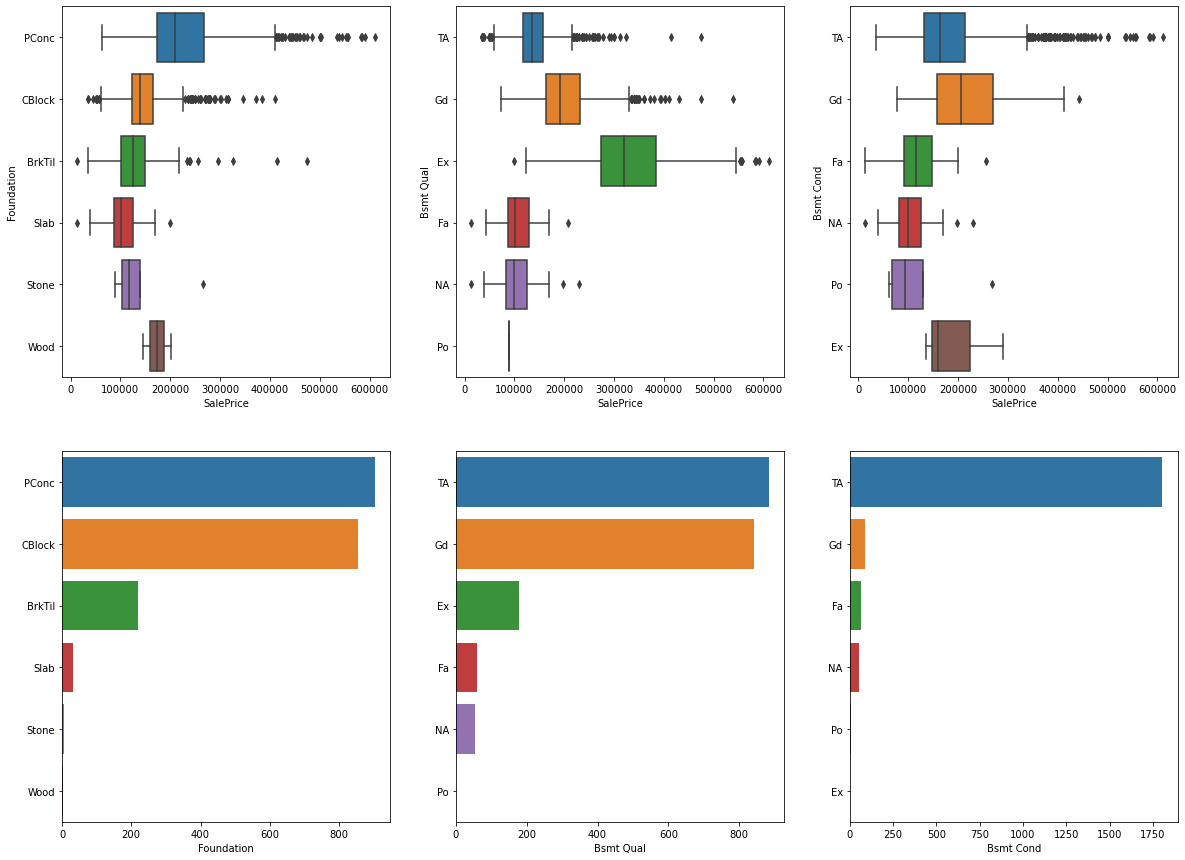

In [145]:
boxplot_count_subplot('SalePrice', ['Foundation', 'Bsmt Qual', 'Bsmt Cond'], data=data, row=2 , col=3, figure_size=(20, 15))

- Bsmt Qual to be included in list as SalePrice varies differently for each label

In [146]:
usable_model_features_list.extend(['Bsmt Qual'])

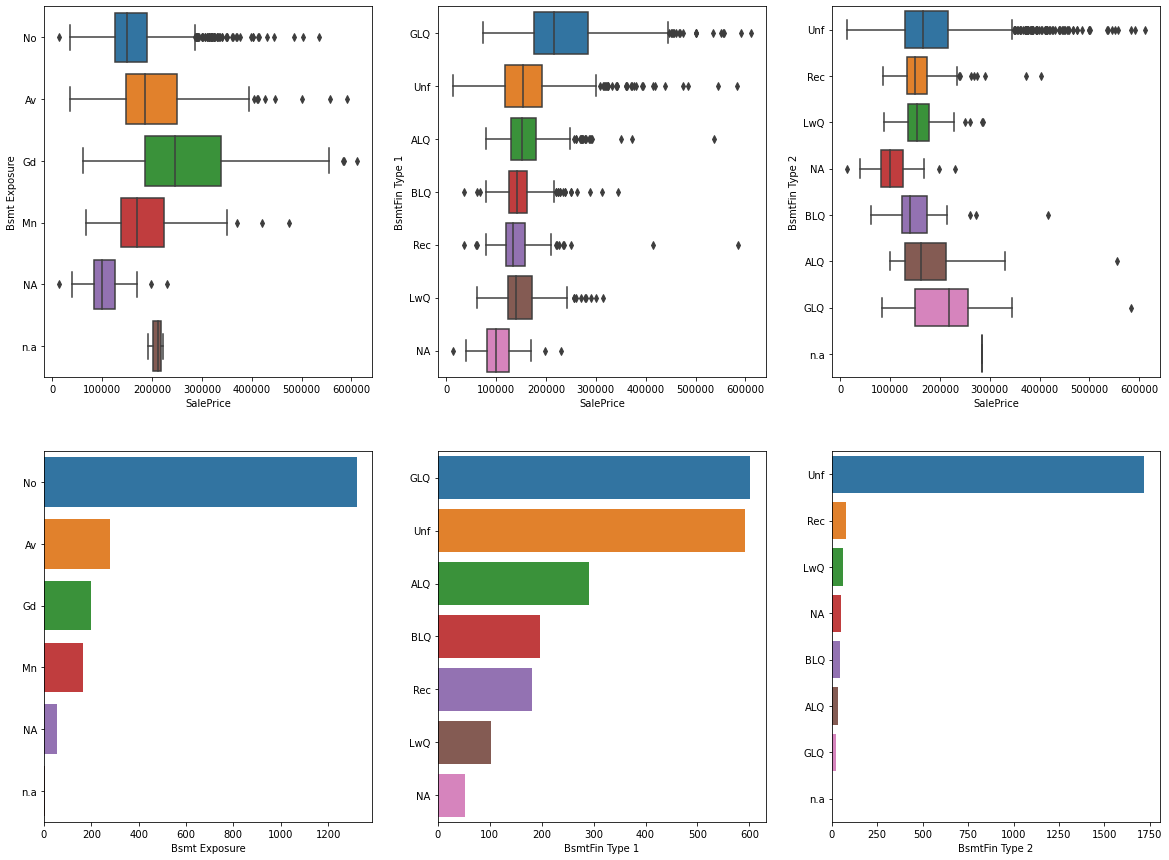

In [147]:
boxplot_count_subplot('SalePrice', ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2'], data=data, row=2 , col=3, figure_size=(20, 15))

- Bsmt Exposure as primary as each category has distinct SalePrice

In [148]:
usable_model_features_list.extend(['Bsmt Exposure'])

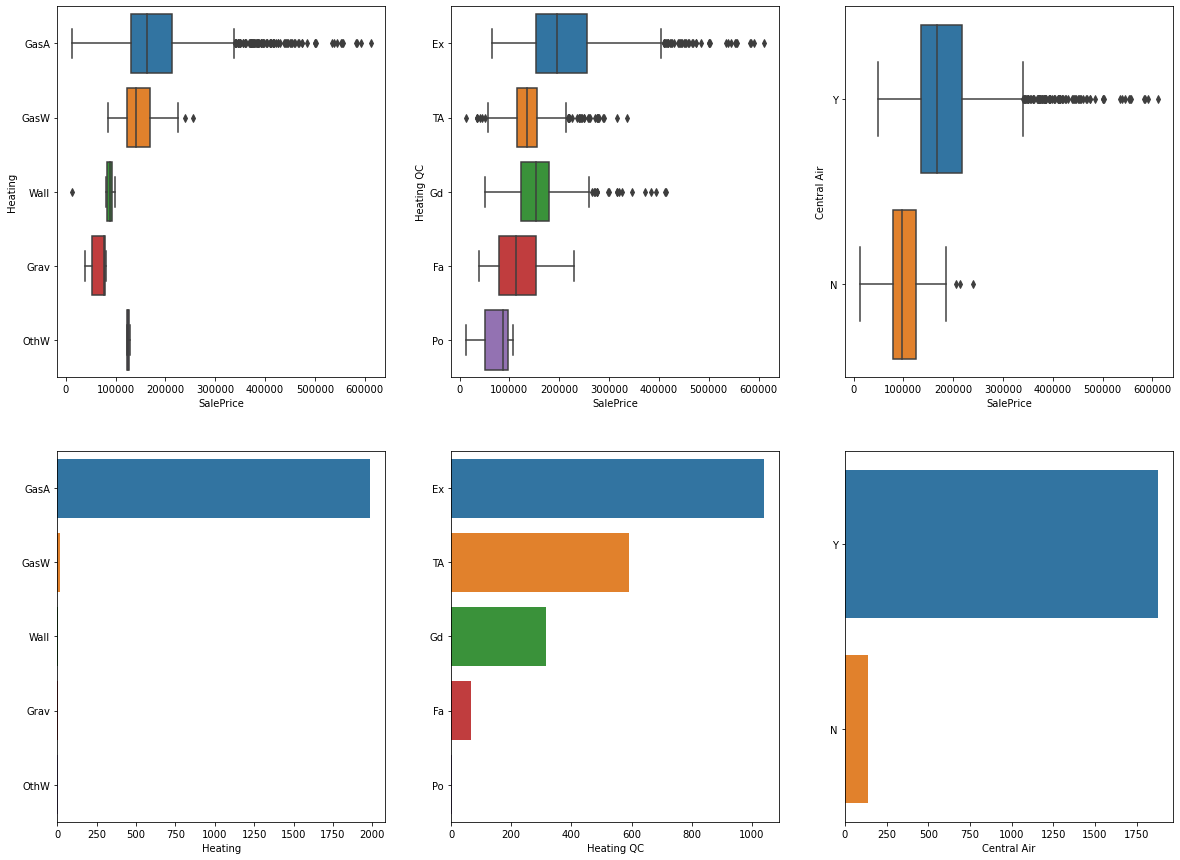

In [149]:
boxplot_count_subplot('SalePrice', ['Heating', 'Heating QC', 'Central Air'], data=data, row=2 , col=3, figure_size=(20, 15))

- Heating QC and Central Air to be included as each category has distinct SalePrice

In [150]:
usable_model_features_list.extend(['Heating QC', 'Central Air'])

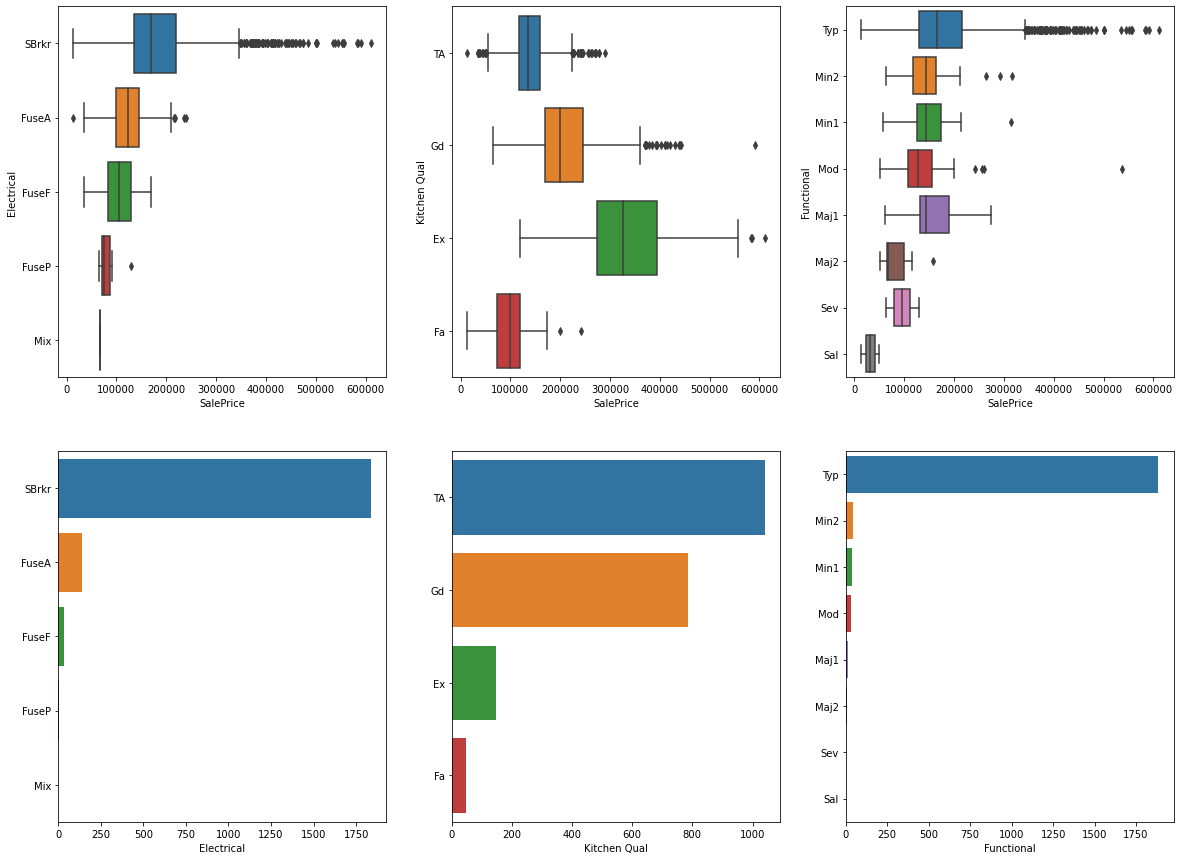

In [151]:
boxplot_count_subplot('SalePrice', ['Electrical', 'Kitchen Qual', 'Functional'], data=data, row=2 , col=3, figure_size=(20, 15))

- Electrical and Kitchen Qual to be included as there is distinct Sale Price for each group
    - However for Electriical, the proportion of houses is skewed towards SBrkr

In [152]:
usable_model_features_list.extend(['Electrical', 'Kitchen Qual'])

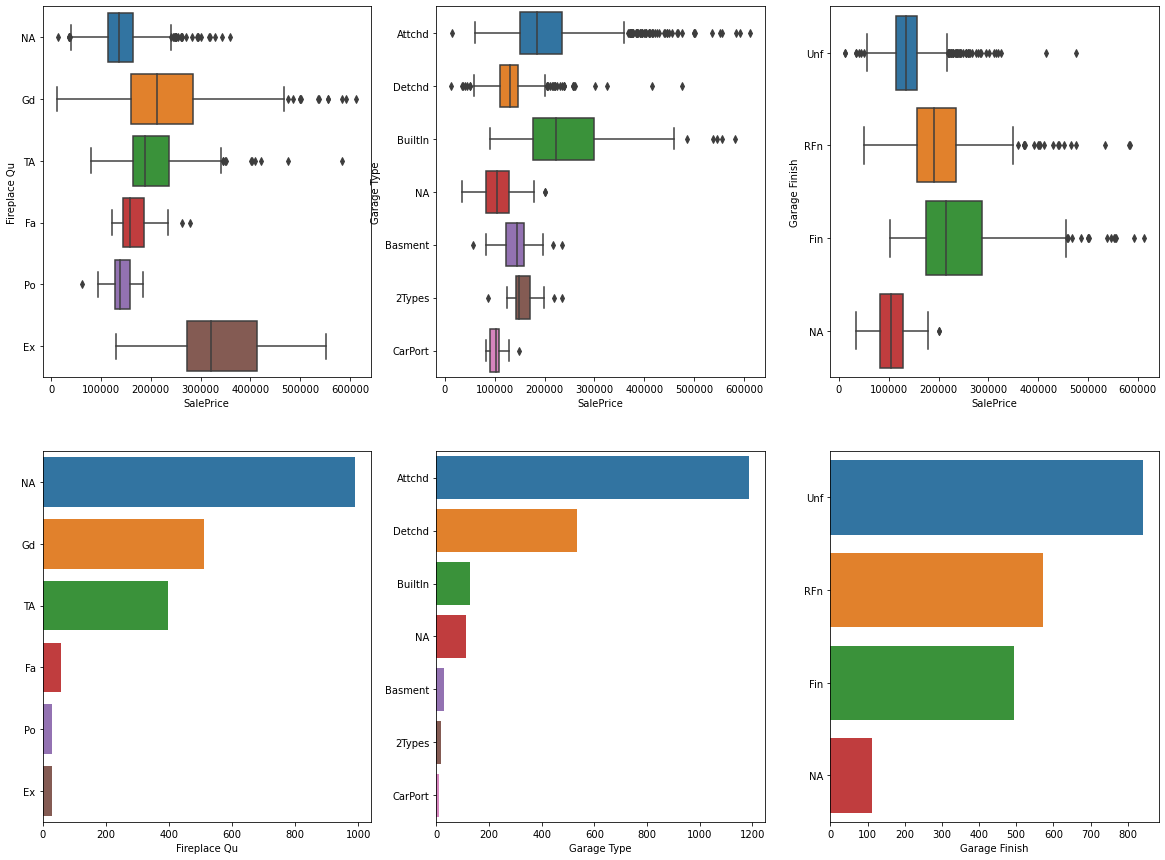

In [153]:
boxplot_count_subplot('SalePrice', ['Fireplace Qu', 'Garage Type', 'Garage Finish'], data=data, row=2 , col=3, figure_size=(20, 15))

- Fireplace Qu, Garage Type and Garage Finish to be added to list as there is SalePrice distinction for each group

In [154]:
usable_model_features_list.extend(['Fireplace Qu', 'Garage Type', 'Garage Finish'])

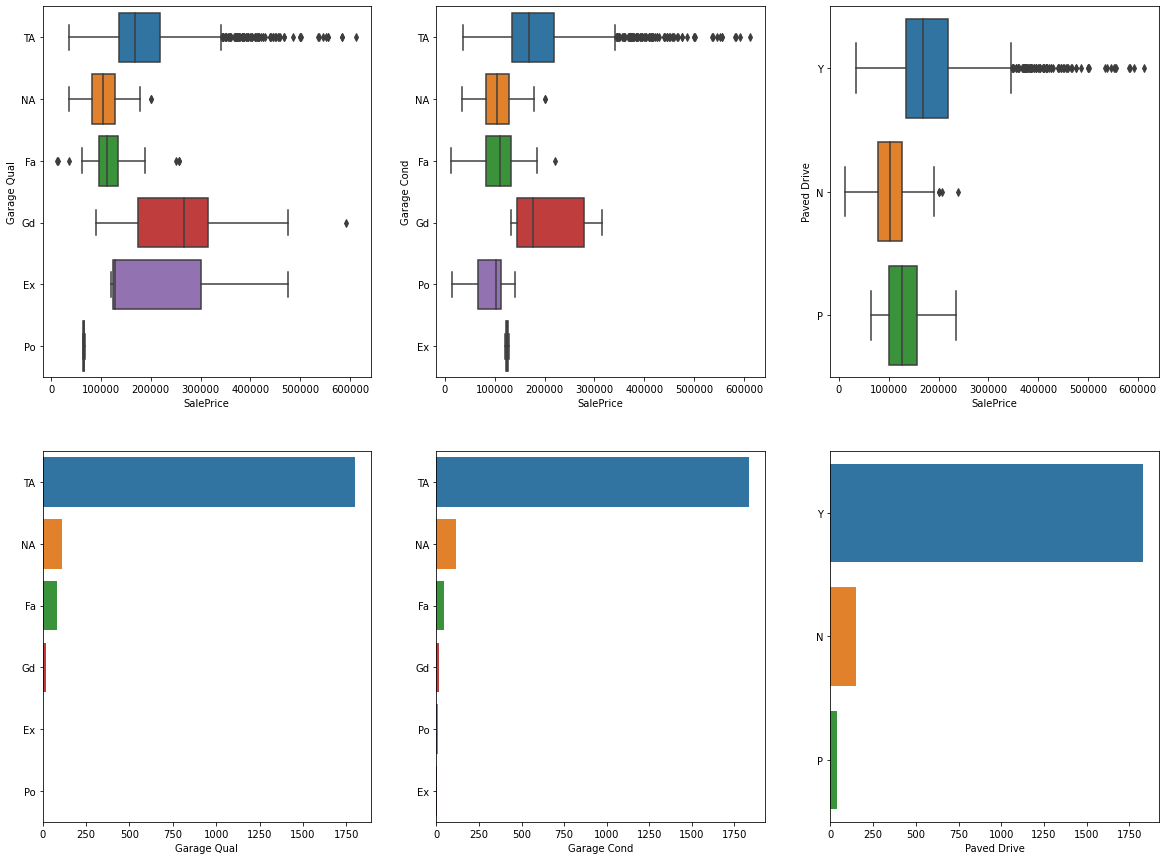

In [155]:
boxplot_count_subplot('SalePrice', ['Garage Qual', 'Garage Cond', 'Paved Drive'], data=data, row=2 , col=3, figure_size=(20, 15))

- To drop Garage Cond and Paved Drive as the median value for each group does not differ from each other too significantly and value counts are low for most categories

In [156]:
usable_model_features_list.extend(['Garage Qual'])

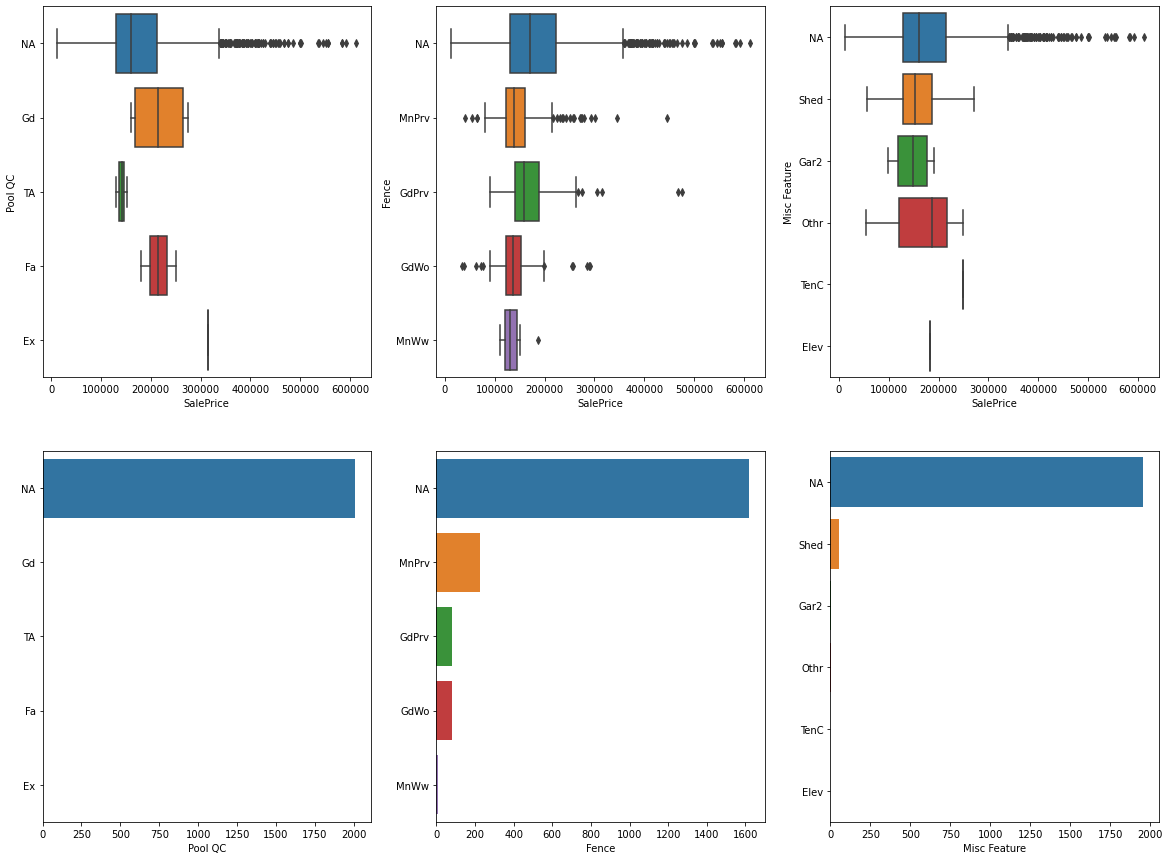

In [157]:
boxplot_count_subplot('SalePrice', ['Pool QC', 'Fence', 'Misc Feature'], data=data, row=2 , col=3, figure_size=(20, 15))

- To drop Pool QC and Misc Feature due low counts despite certain categories have distinct SalePrice 
- To drop Fence due to similar SalePrice between each category

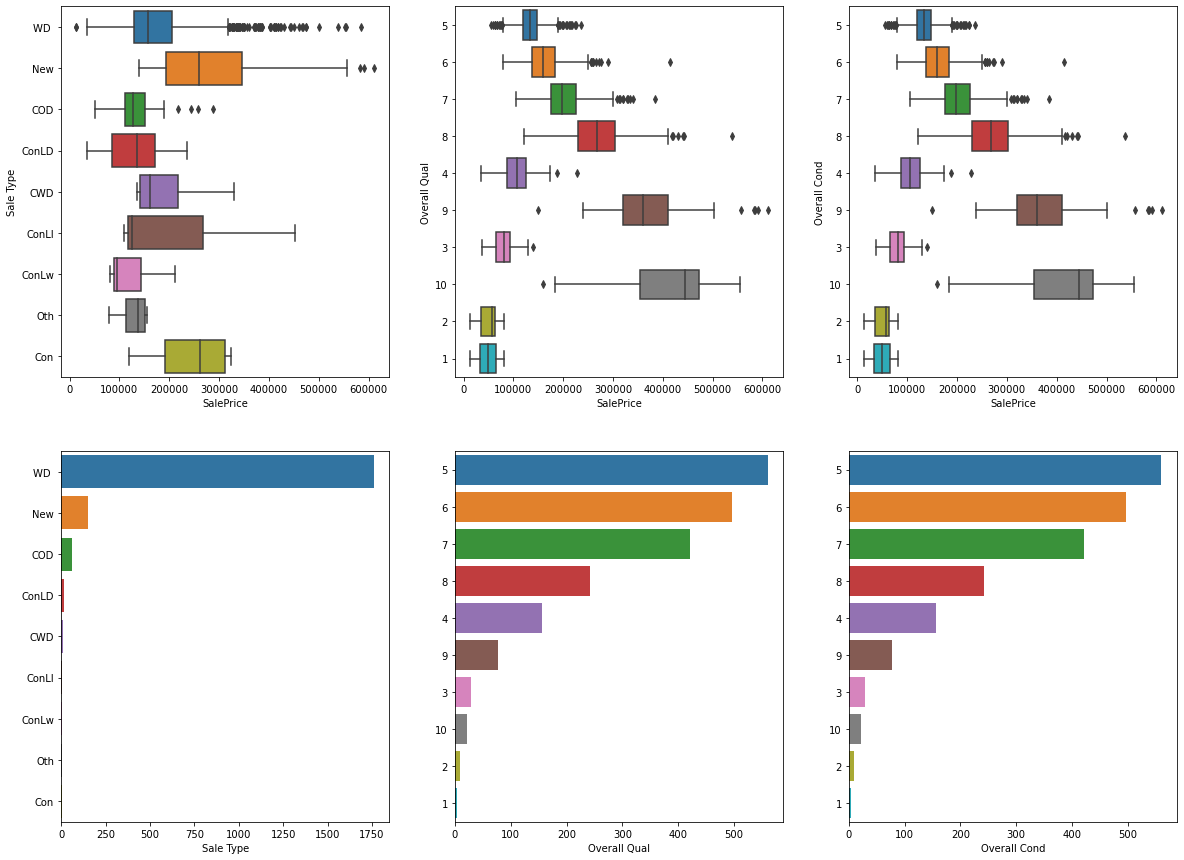

In [158]:
boxplot_count_subplot('SalePrice', ['Sale Type', 'Overall Qual', 'Overall Cond'], data=data, row=2 , col=3, figure_size=(20, 15))

- Overall Qual and Overall Cond as potential features for model as the categories are showing different SalePrice

In [159]:
usable_model_features_list.extend(['Overall Qual', 'Overall Cond'])

The selected features to be used for modeling are:-
- Age_Sold
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Total SF
- Lot Area
- Mas Vnr Area
- Gr Liv Area
- Overall Qual
- Full Bath
- No Of Bath
- TotRms AbvGrd
- Garage Area
- Amenities SF
- Fireplaces
- Open Porch SF
- Enclosed Porch
- 3Ssn Porch
- Screen Porch
- Total Porch SF
- MS SubClass
- MS Zoning
- Land Contour
- Neighborhood
- Condition 1
- Condition 2
- House Style
- Exterior 1st
- Exterior 2nd
- Mas Vnr Type
- Exter Qual
- Bsmt Qual
- Bsmt Exposure
- Heating QC
- Central Air
- Electrical
- Kitchen Qual
- Fireplace Qu
- Garage Type
- Garage Finish

However some features are colinear to each other, so they might be use exclusive from each other.